In [1]:
import numpy as np
import pandas as pd

from mrashpen.inference.penalized_regression import PenalizedRegression as PLR
from mrashpen.inference.mrash_wrapR          import MrASHR
from mrashpen.models.plr_ash                 import PenalizedMrASH
from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled
from mrashpen.inference.ebfit                import ebfit
from mrashpen.inference                      import lbfgsfit
from mrashpen.utils                          import R_lasso
from mrashpen.inference                      import elbo as elbo_py
from mrashpen.inference                      import coordinate_descent_step as cd_step

import sys
sys.path.append('/home/saikat/Documents/work/sparse-regression/simulation/eb-linreg-dsc/dsc/functions')
import simulate

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')


def center_and_scale(Z):
    dim = Z.ndim
    if dim == 1:
        Znew = Z / np.std(Z)
        Znew = Znew - np.mean(Znew)
    elif dim == 2:
        Znew = Z / np.std(Z, axis = 0)
        Znew = Znew - np.mean(Znew, axis = 0).reshape(1, -1)
    return Znew

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

def plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, bhat, 
                         intercept = 0, title = None):
    ypred = np.dot(Xtest, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(ytest, ypred, s = 2, alpha = 0.5)
    mpl_utils.plot_diag(ax1)
    ax2.scatter(btrue, bhat)
    mpl_utils.plot_diag(ax2)

    ax1.set_xlabel("Y_test")
    ax1.set_ylabel("Y_predicted")
    ax2.set_xlabel("True b")
    ax2.set_ylabel("Predicted b")
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
    
def plot_convergence(objs, methods, nwarm, eps = 1e-8):
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(111)

    objmin  = np.min([np.min(x) for x in objs])

    for obj, method, iteq in zip(objs, methods, nwarm):
        m_obj = obj[iteq:] - objmin
        m_obj = m_obj[m_obj > 0]
        ax1.plot(range(iteq, len(m_obj) + iteq), np.log10(m_obj), label = method, 
                 marker = 'o', markersize = 1)
    ax1.legend()

    ax1.set_xlabel("Number of Iterations")
    ax1.set_ylabel("log( max(ELBO) - ELBO )")

    plt.show()
    return

def plot_trendfilter_mrashpen(X, y, beta, ytest, bhat,
                              intercept = 0, title = None):
    n = y.shape[0]
    p = X.shape[1]

    ypred = np.dot(X, bhat) + intercept
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(np.arange(n), ytest, edgecolor = 'black', facecolor='white')
    ax1.plot(np.arange(n), ypred)
    ax1.set_xlabel("Sample index")
    ax1.set_ylabel("Y")

    ax2.scatter(np.arange(p), beta, edgecolor = 'black', facecolor = 'white')
    ax2.scatter(np.arange(p), bhat, s = 40, color = 'firebrick')
    ax2.set_xlabel("Sample index")
    ax2.set_ylabel("b")
    
    if title is not None:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()
    
def linreg_summary_df(sigma2, objs, methods):
    data     = [[strue * strue,  '-', '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.elbo_path[-1], obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'ELBO', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

def linreg_summary_df_noelbo(sigma2, objs, methods):
    data     = [[strue * strue, '-']]
    rownames = ['True']
    for obj, method in zip(objs, methods):
        data.append([obj.residual_var, obj.niter])
        rownames.append(method)
    colnames = ['sigma2', 'niter']
    df = pd.DataFrame.from_records(data, columns = colnames, index = rownames)
    return df

def get_elbos(X, y, b, w, sk, s2):
    elbo1 = cd_step.elbo(X, y, sk, b, w, s2)

    dj     = np.sum(np.square(X), axis = 0)
    r      = y - np.mean(y) - np.dot(X, b)
    btilde = b + np.dot(X.T, r) / dj
    nmash  = NormalMeansASHScaled(btilde, np.sqrt(s2), w, sk, d = dj, debug = False)
    phijk, mujk, varjk = nmash.posterior()
    elbo2  = elbo_py.scalemix(X, y, sk, b, w, s2,
                              dj = dj, phijk = phijk, mujk = mujk, varjk = varjk, eps = 1e-8)
    return elbo1, elbo2

In [2]:
n = 200
p = 2000
p_causal = 50
pve = 0.95
rho = 0.0
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = rho, seed = 100)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

In [3]:
'''
Lasso initialization
'''
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)

'''
mr.ash.pen
'''
# plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = False, is_prior_scaled = True,
#                 debug = False, display_progress = False, calculate_elbo = True, maxiter = 2000)
# plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = s2init)
plr_lbfgs = lbfgsfit.method_oneup(X, y, sk, wk, binit = lasso_b, s2init = s2init, calculate_elbo = True)


'''
mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, wk, binit = lasso_b, s2init = 1, maxiter = 400, qb_maxiter = 50)


'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = lasso_b, winit = wk, s2init = 1)


'''
mr.ash.alpha (init)
'''
mrash_r_init = MrASHR(option = "r2py", debug = False)
mrash_r_init.fit(X, y, sk, binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

R[write to console]: Loading required package: Matrix



mr.ash.pen terminated at iteration 29.
mr.ash.pen terminated at iteration 3948.
mr.ash.pen terminated at iteration 6.
mr.ash.pen terminated at iteration 952.
mr.ash.pen (EM) terminated at iteration 400.
Mr.ASH terminated at iteration 730.
Mr.ASH terminated at iteration 261.


In [5]:
lasso_b[np.abs(lasso_b) > 0.01]

array([ 0.1554228 ,  0.5442423 , -0.02630098, -0.11104935,  0.2125897 ,
       -0.0489352 ,  0.30395734,  0.17335929,  0.04923585,  0.72852973,
       -0.01748239,  0.28244125,  0.0929128 , -1.48984401,  0.09412264,
        0.06395811,  0.17304902,  0.36838014,  0.12186   ,  0.41994009,
       -0.03164602,  0.07543668, -1.27334143,  0.17215325, -0.17166904,
       -0.04015228,  0.04712828,  0.35681445,  0.89669584,  0.02726397,
        0.17309268, -0.22963605,  2.56362866, -0.20804773,  0.07834794,
       -0.23682128, -0.05954213,  0.30152794, -0.2302125 , -0.04915196,
       -0.0472189 , -0.13475167, -1.15853128, -0.06737393,  0.34782346,
        0.08059443, -0.02336318,  1.31707363,  0.45372395,  0.18971289,
       -0.04692769, -0.09868837, -0.26063263, -0.08775533,  0.09434221,
       -0.01276774, -0.07088904,  0.0283068 , -0.05121019, -0.80368576,
        0.02790528, -0.07894888, -0.03253849,  0.05276161, -0.01856547,
        1.10082903, -0.01204006,  0.0652129 , -0.02112594,  0.17

In [6]:
lasso_a0

0.31348429831466756

In [7]:
s2init

0.05072411219520376

In [8]:
lasso_a0_2, lasso_b_2, _ = R_lasso.fit(X, y)
s2init_2 = np.var(y - np.dot(X, lasso_b_2) - lasso_a0_2)

lasso_a0_2, lasso_b_2, _ = R_lasso.fit(X, y)
s2init_2 = np.var(y - np.dot(X, lasso_b_2) - lasso_a0_2)

In [9]:
lasso_b_2[np.abs(lasso_b) > 0.01]

array([ 0.1554228 ,  0.5442423 , -0.02630098, -0.11104935,  0.2125897 ,
       -0.0489352 ,  0.30395734,  0.17335929,  0.04923585,  0.72852973,
       -0.01748239,  0.28244125,  0.0929128 , -1.48984401,  0.09412264,
        0.06395811,  0.17304902,  0.36838014,  0.12186   ,  0.41994009,
       -0.03164602,  0.07543668, -1.27334143,  0.17215325, -0.17166904,
       -0.04015228,  0.04712828,  0.35681445,  0.89669584,  0.02726397,
        0.17309268, -0.22963605,  2.56362866, -0.20804773,  0.07834794,
       -0.23682128, -0.05954213,  0.30152794, -0.2302125 , -0.04915196,
       -0.0472189 , -0.13475167, -1.15853128, -0.06737393,  0.34782346,
        0.08059443, -0.02336318,  1.31707363,  0.45372395,  0.18971289,
       -0.04692769, -0.09868837, -0.26063263, -0.08775533,  0.09434221,
       -0.01276774, -0.07088904,  0.0283068 , -0.05121019, -0.80368576,
        0.02790528, -0.07894888, -0.03253849,  0.05276161, -0.01856547,
        1.10082903, -0.01204006,  0.0652129 , -0.02112594,  0.17

In [10]:
s2init_2

0.05072411219520376

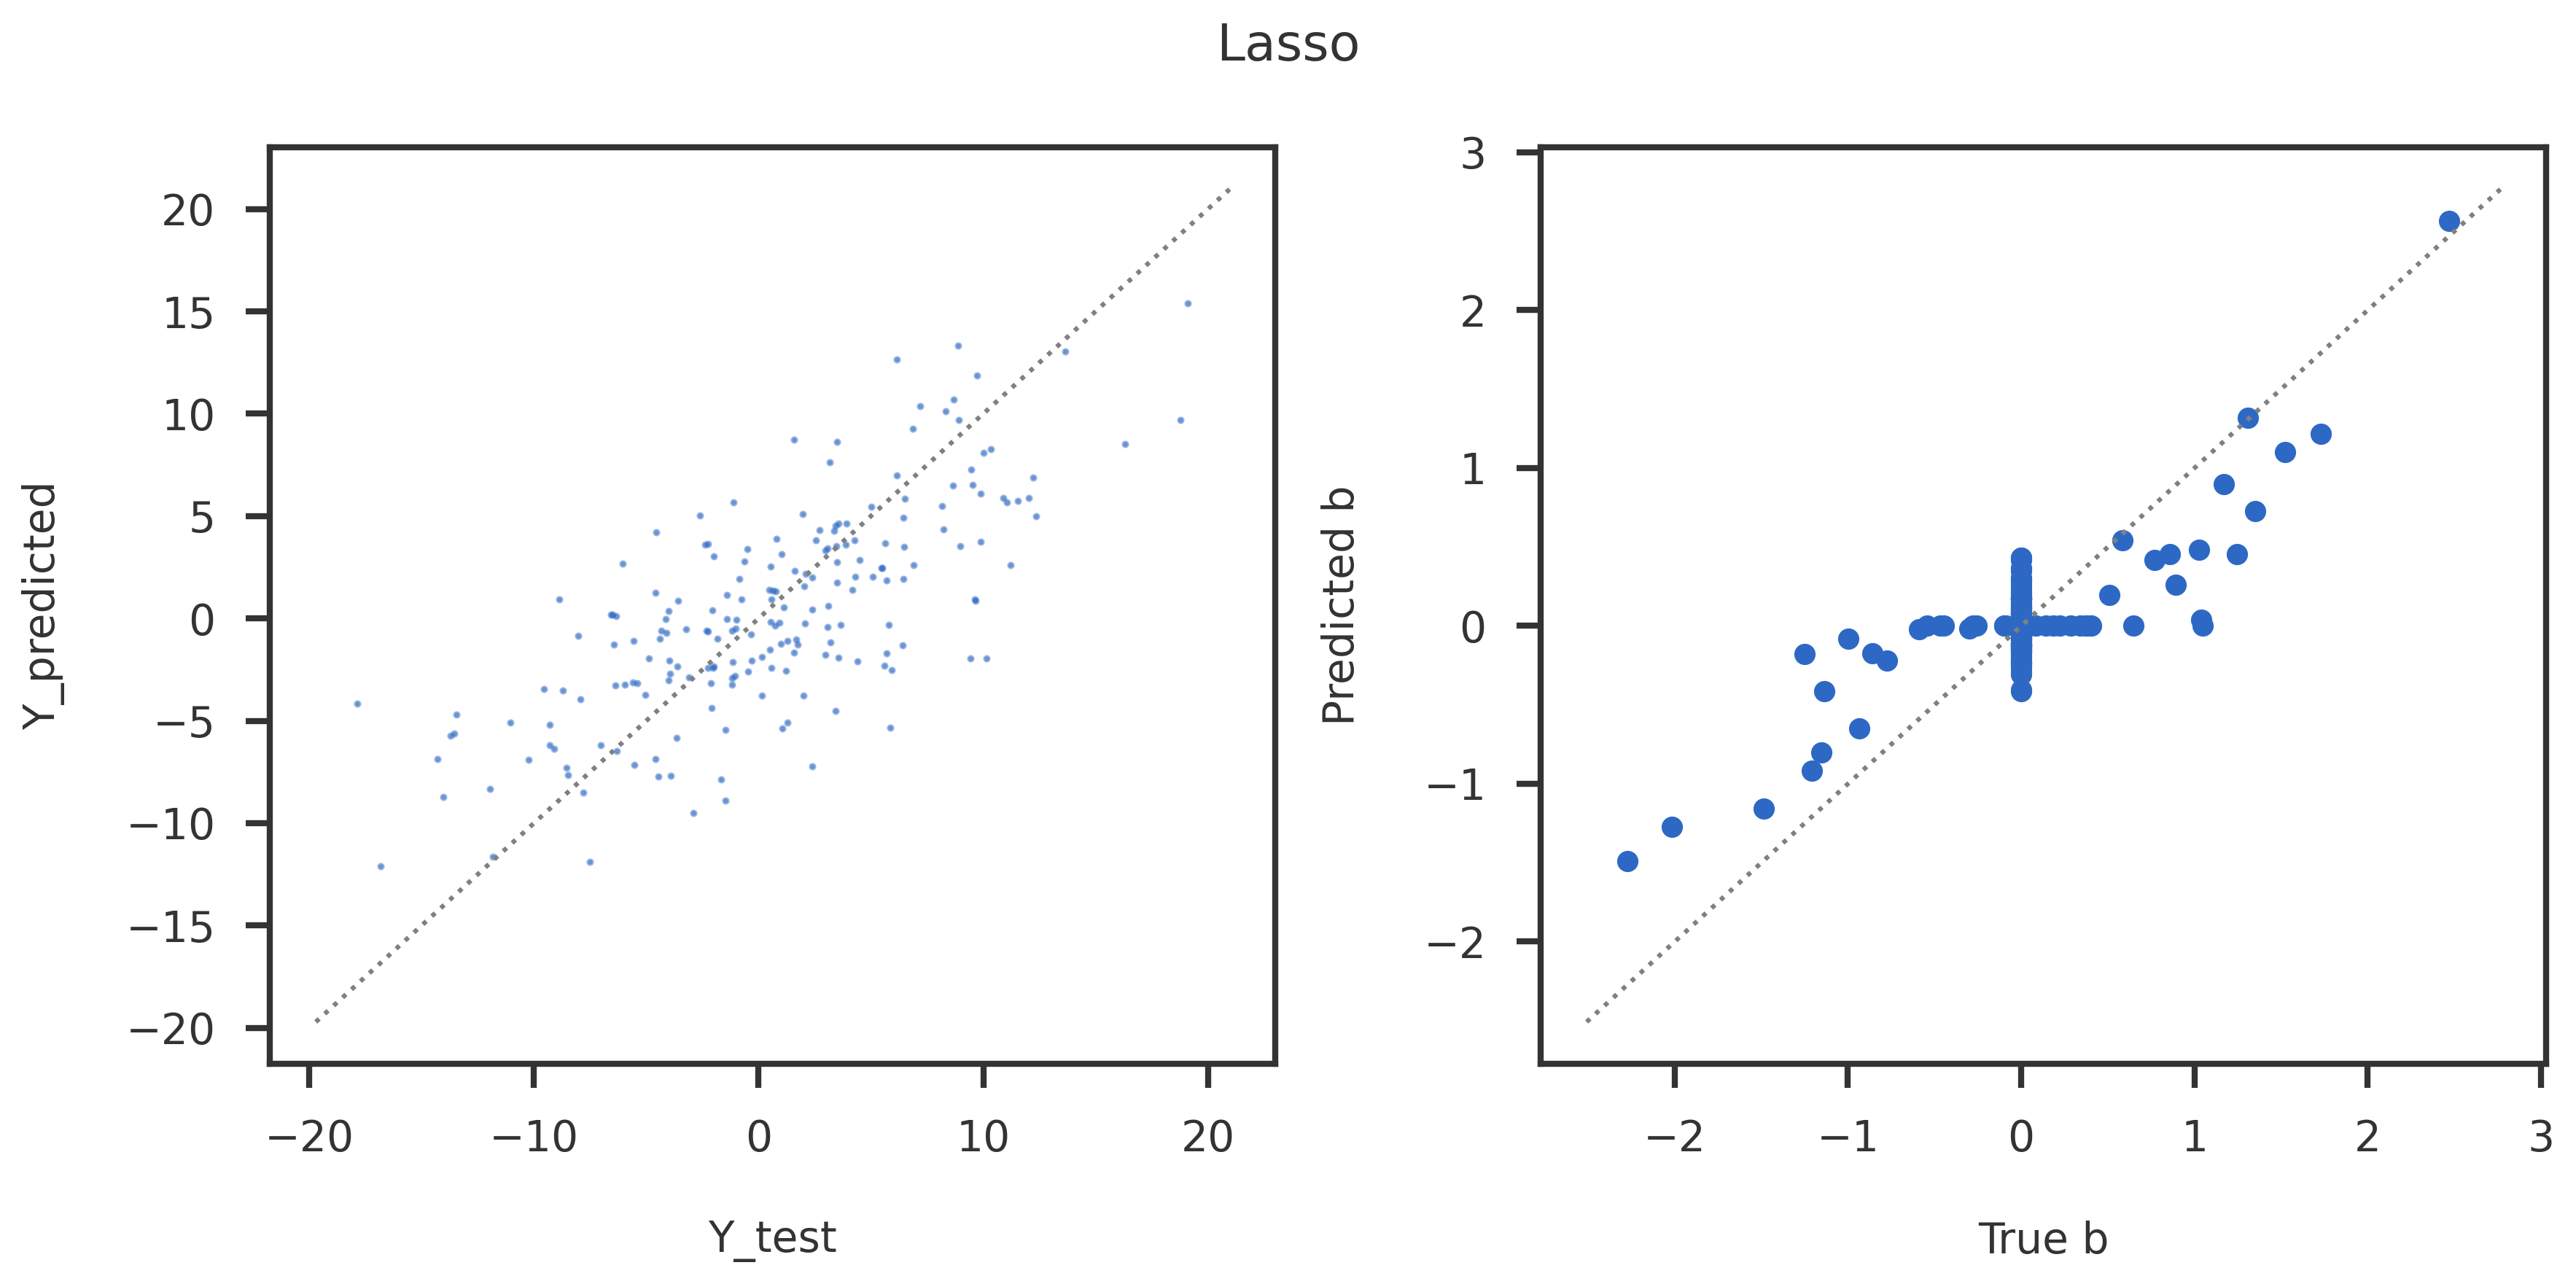

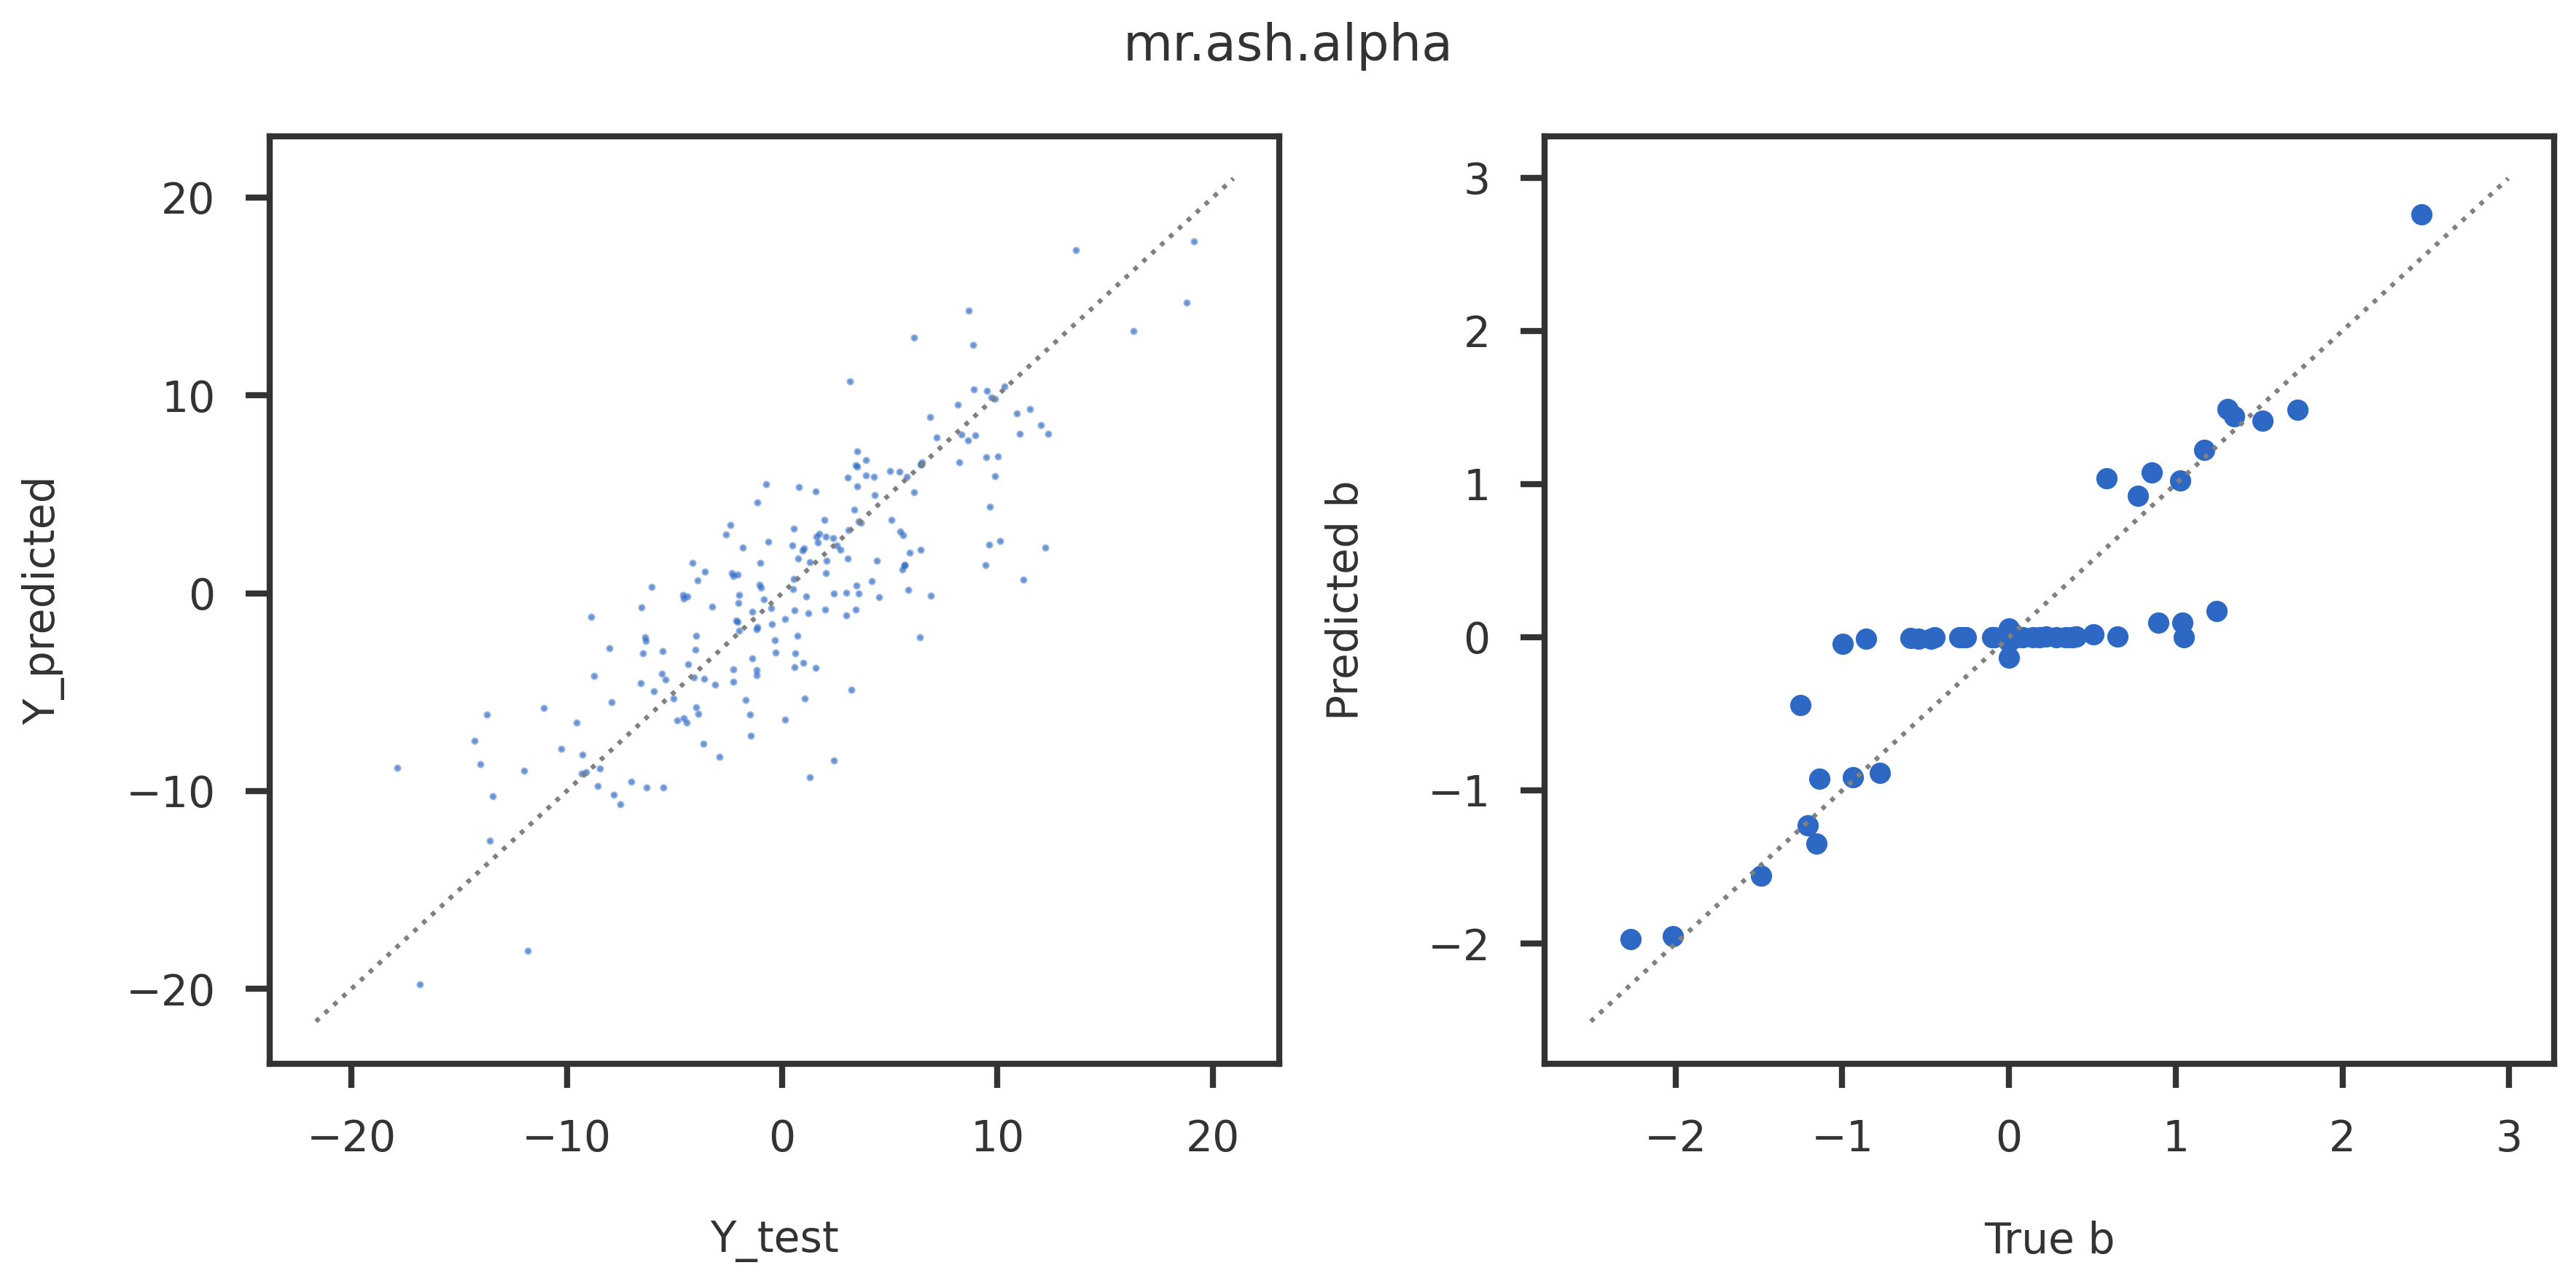

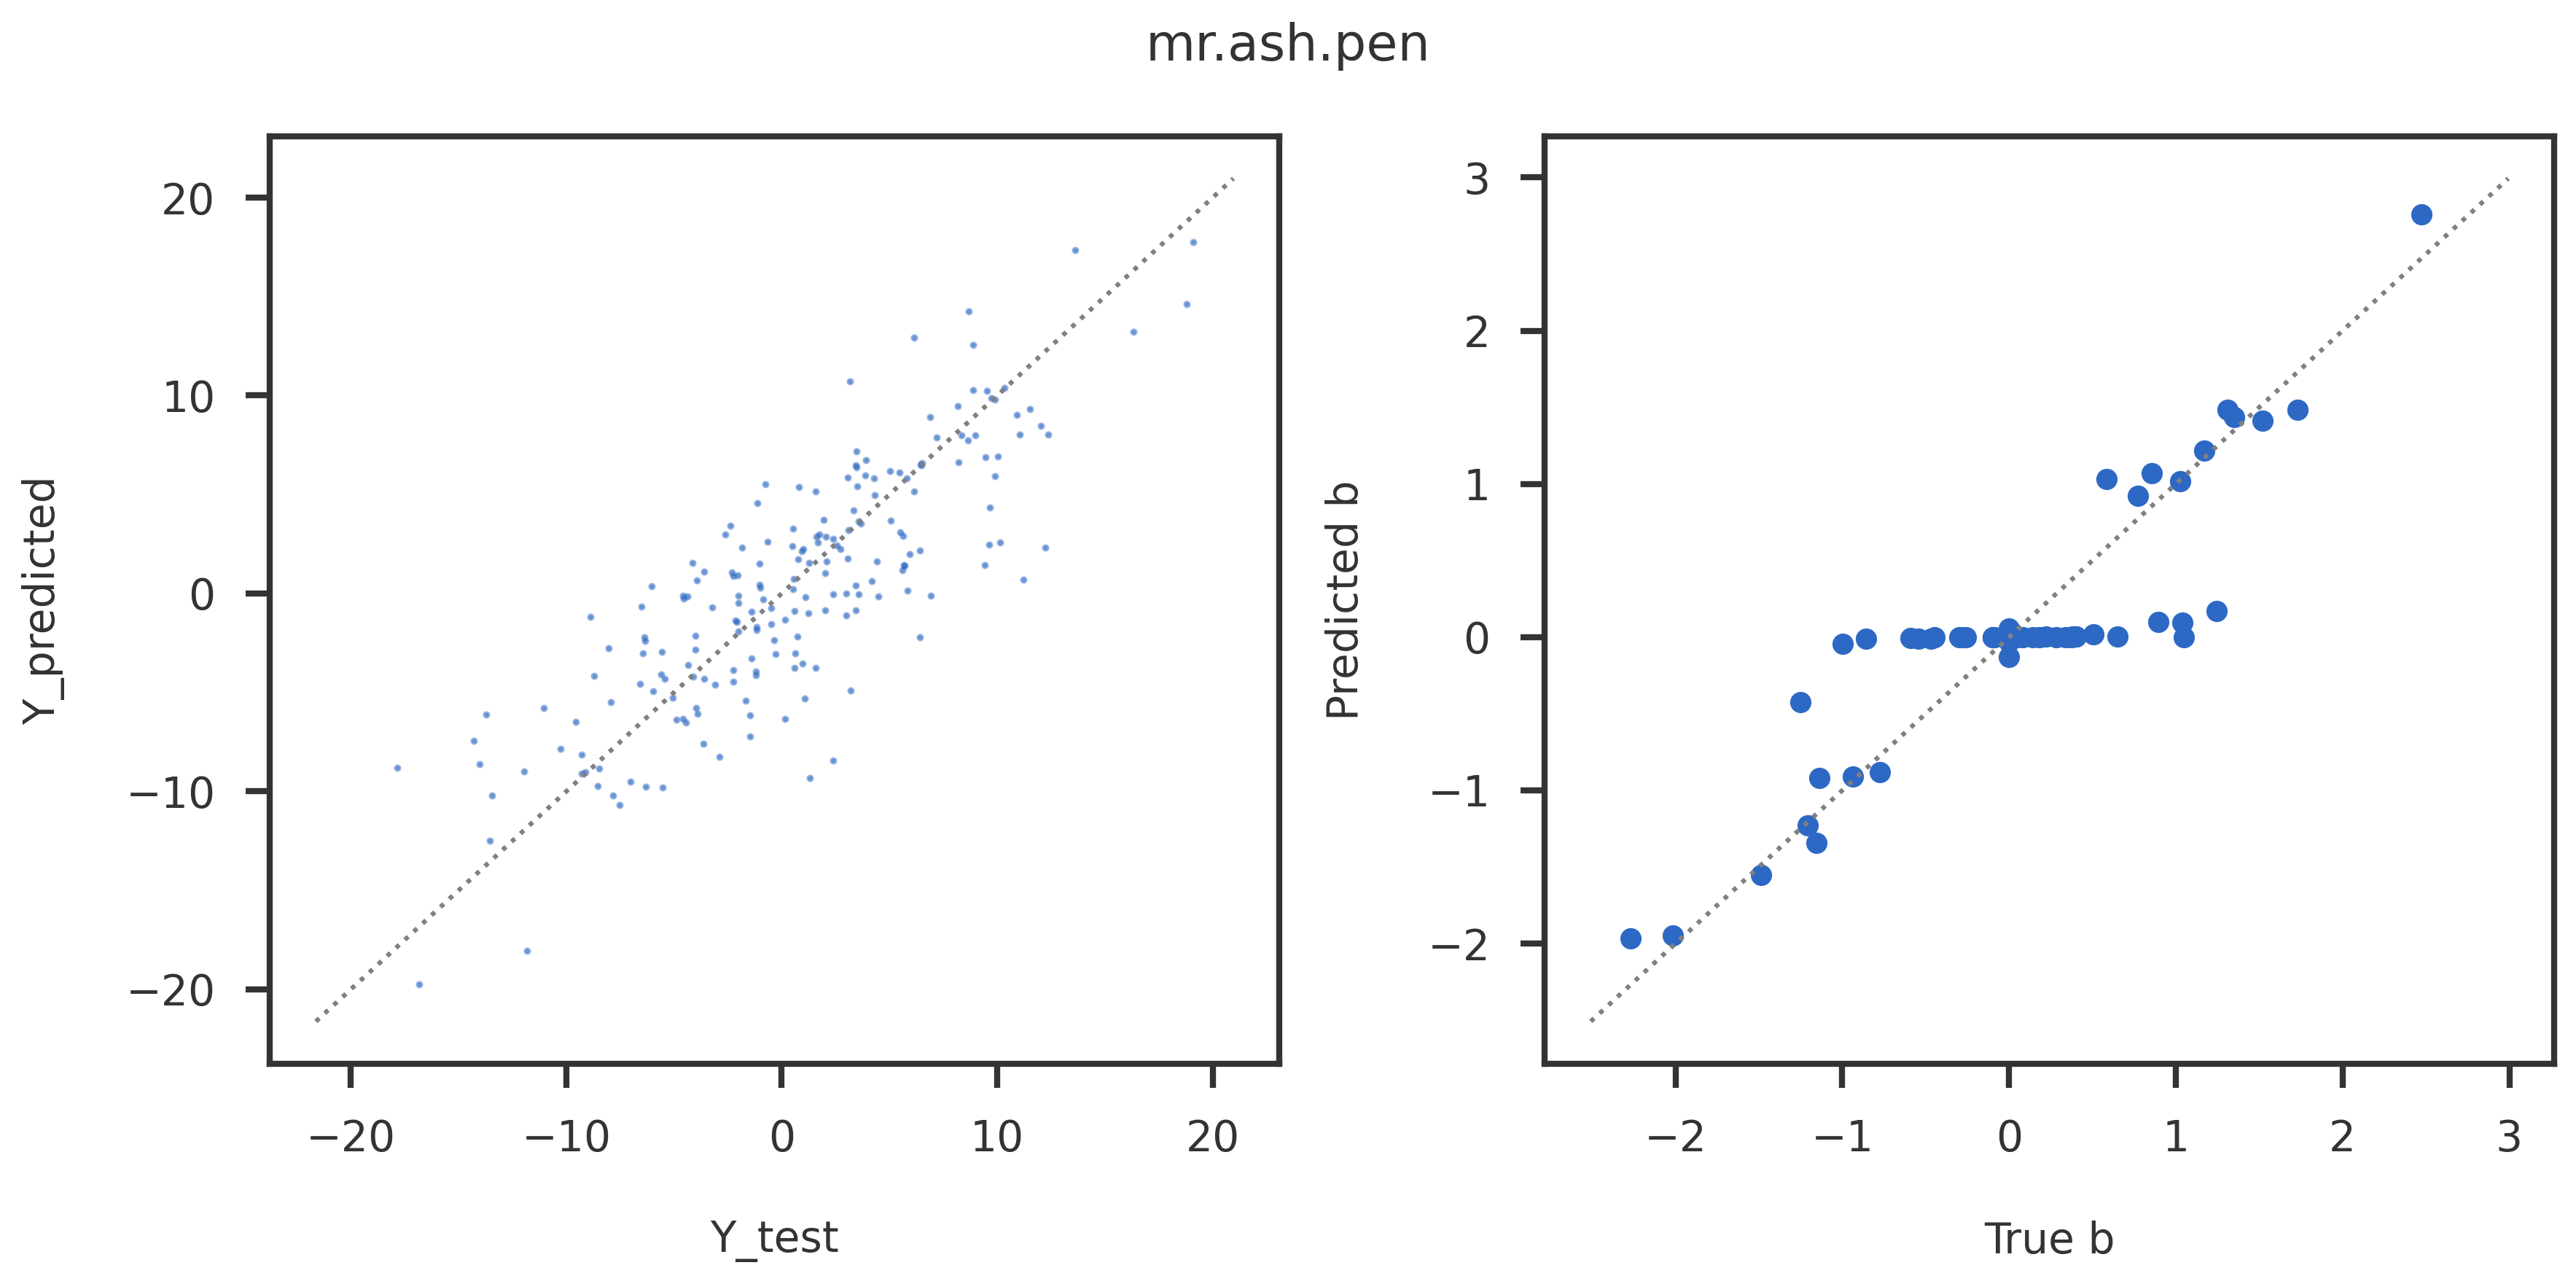

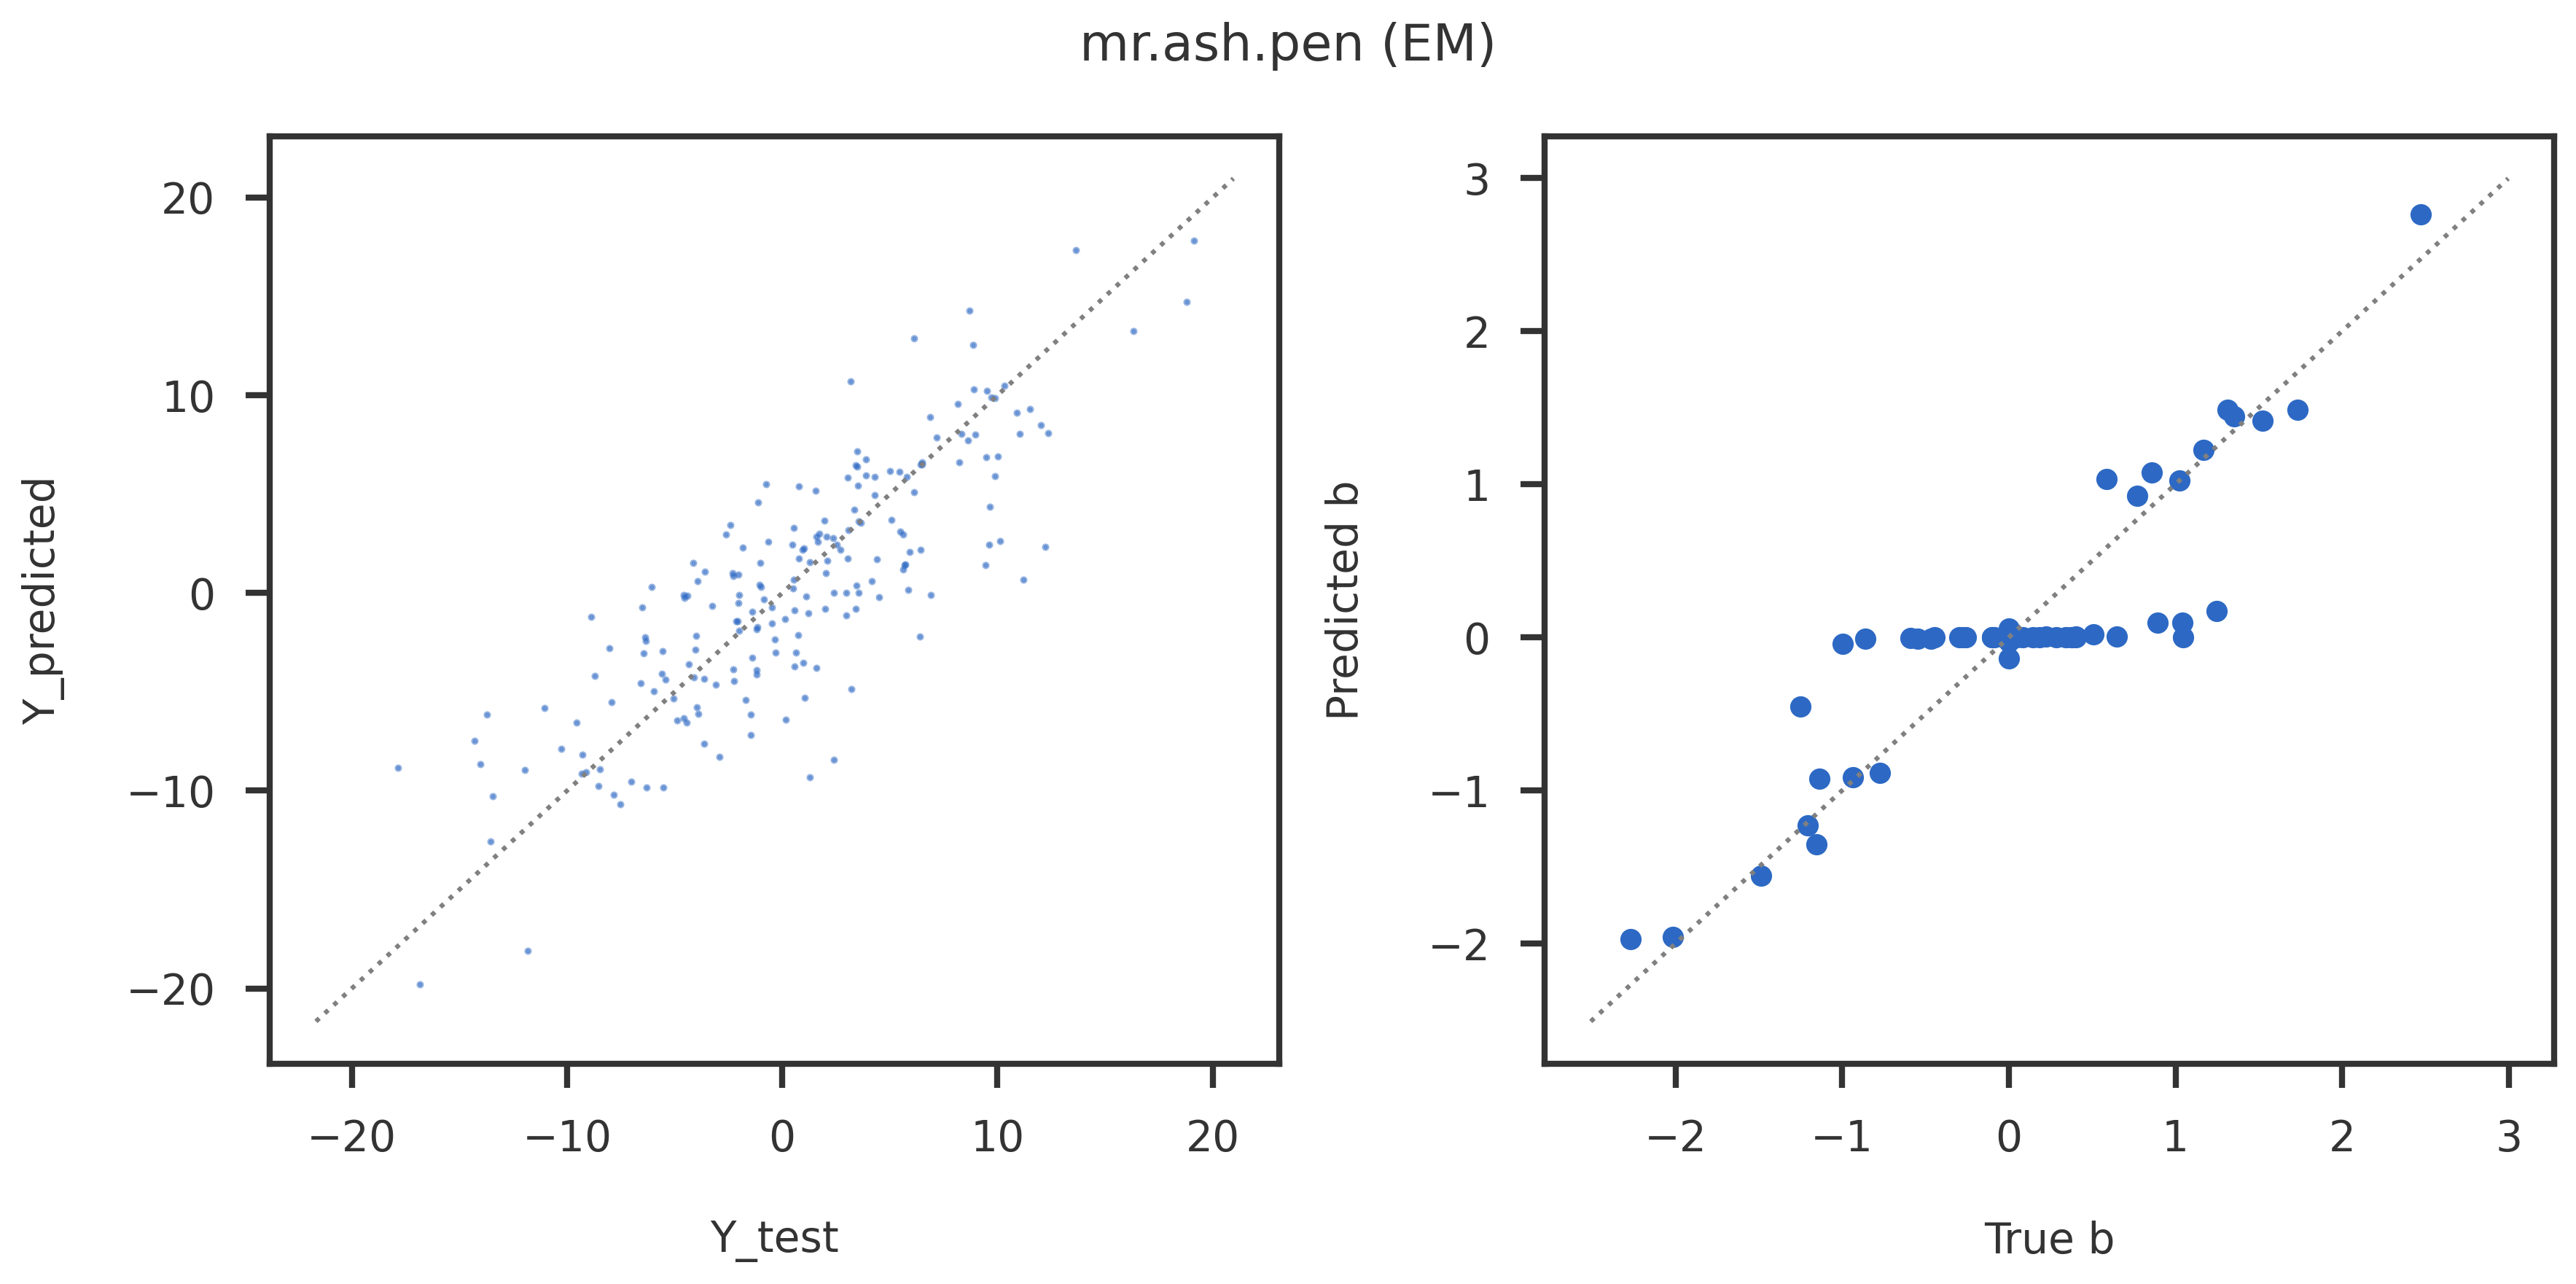

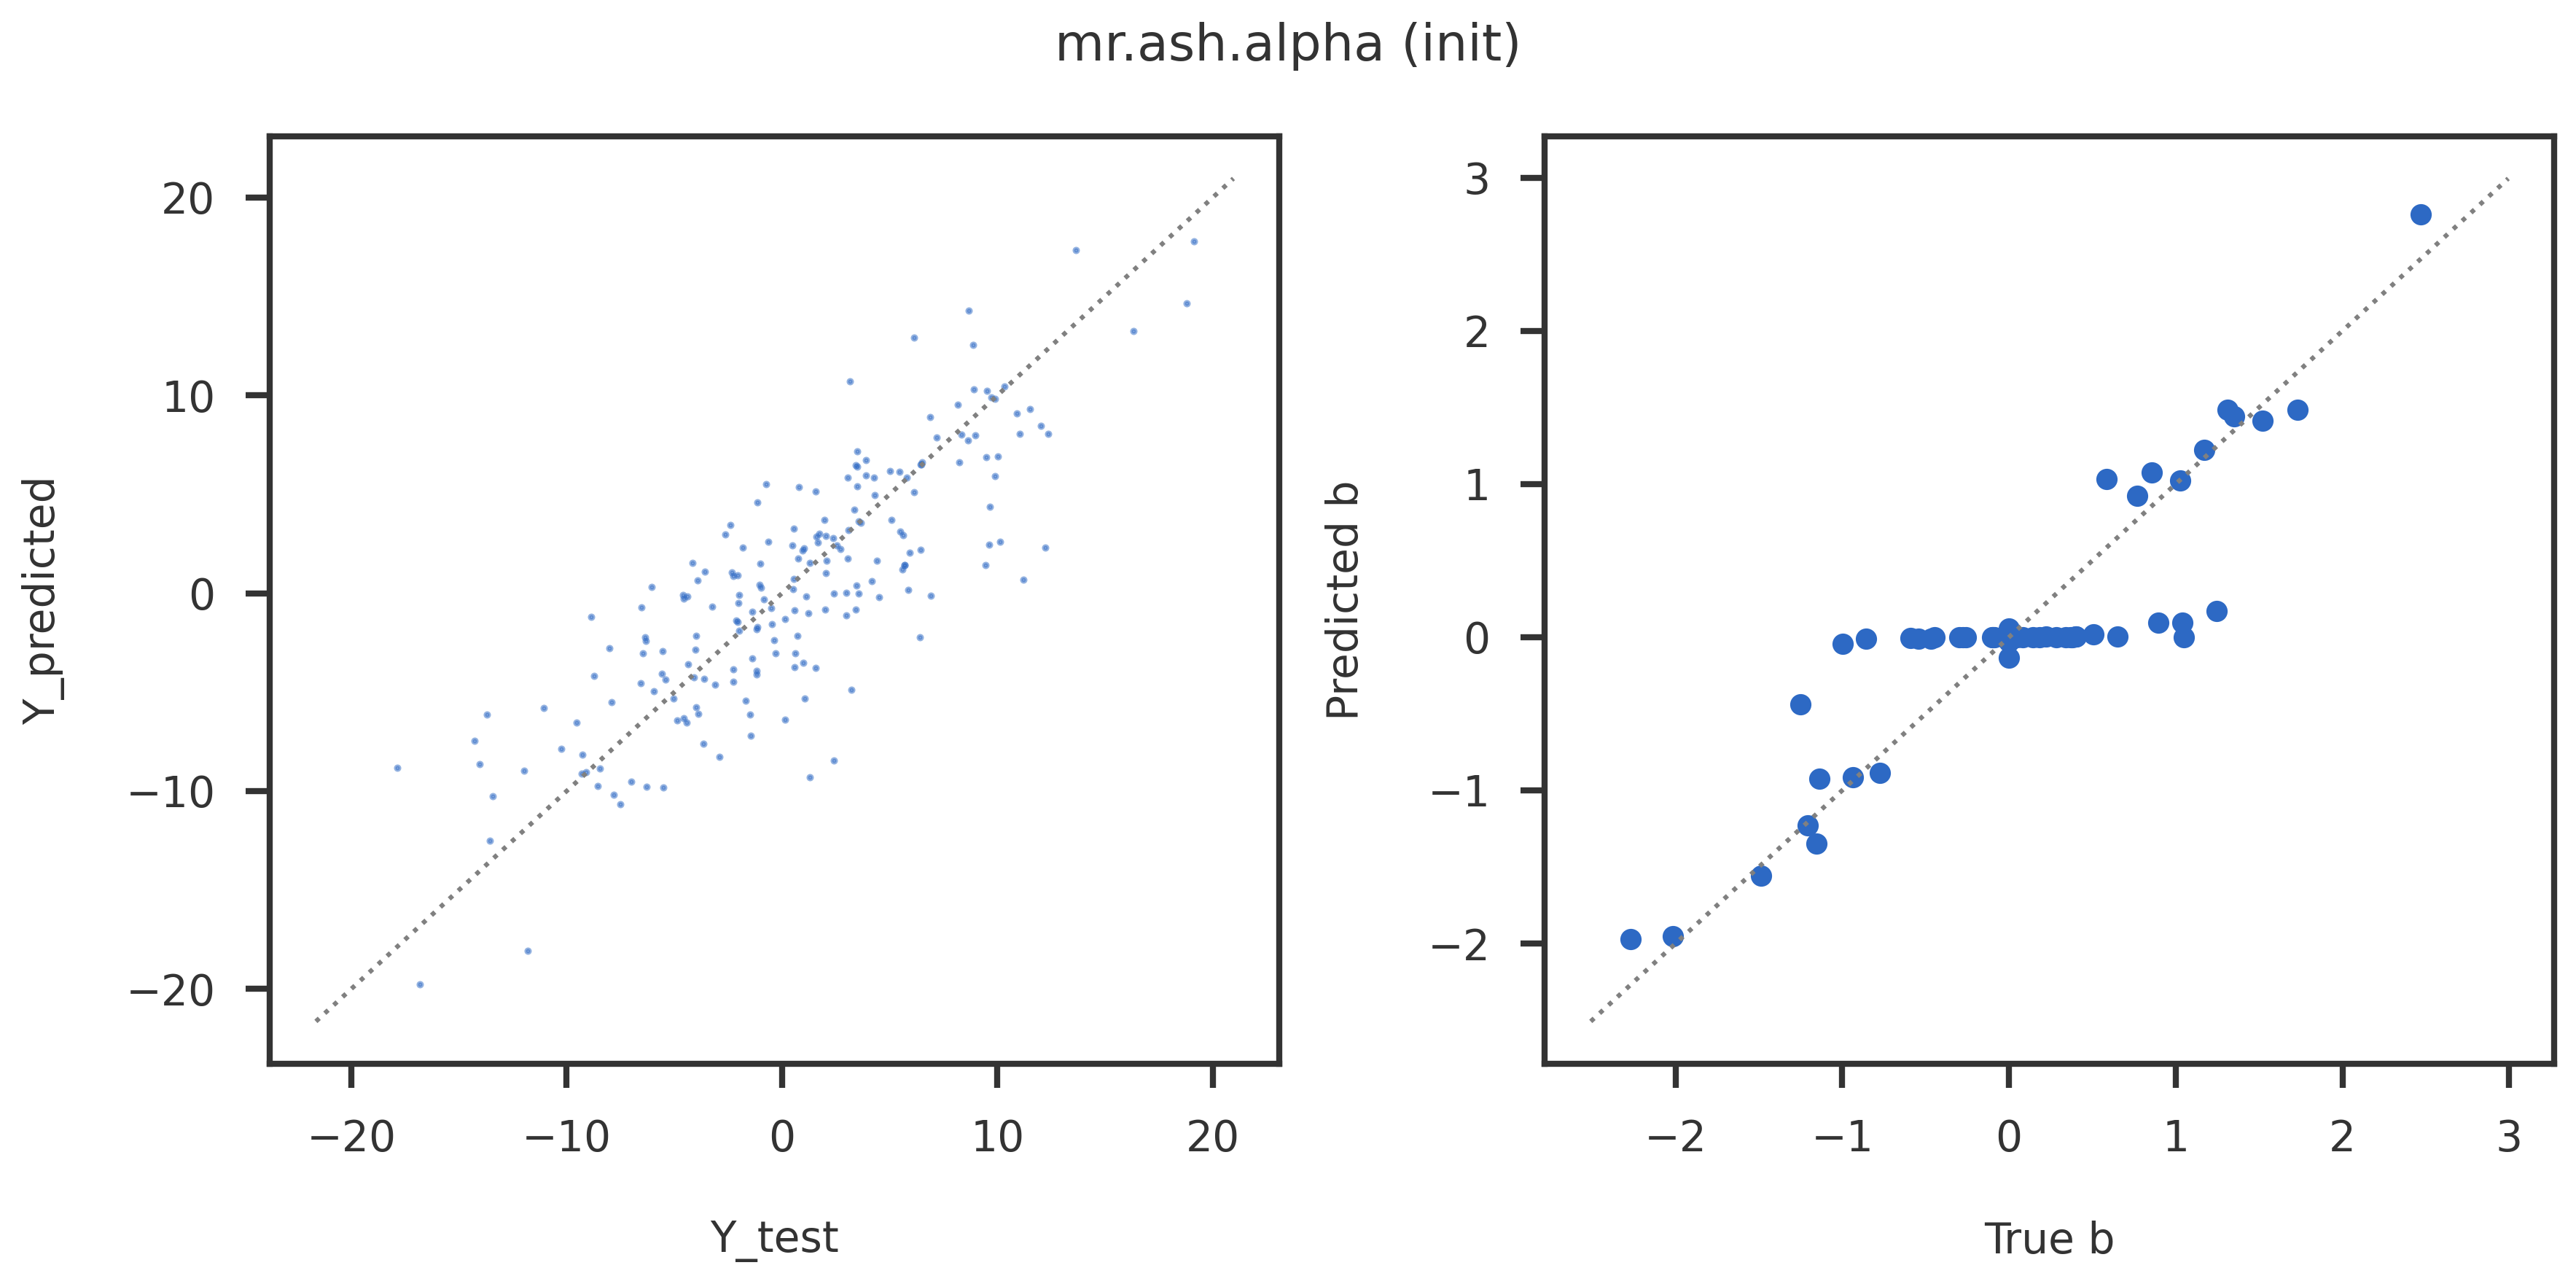

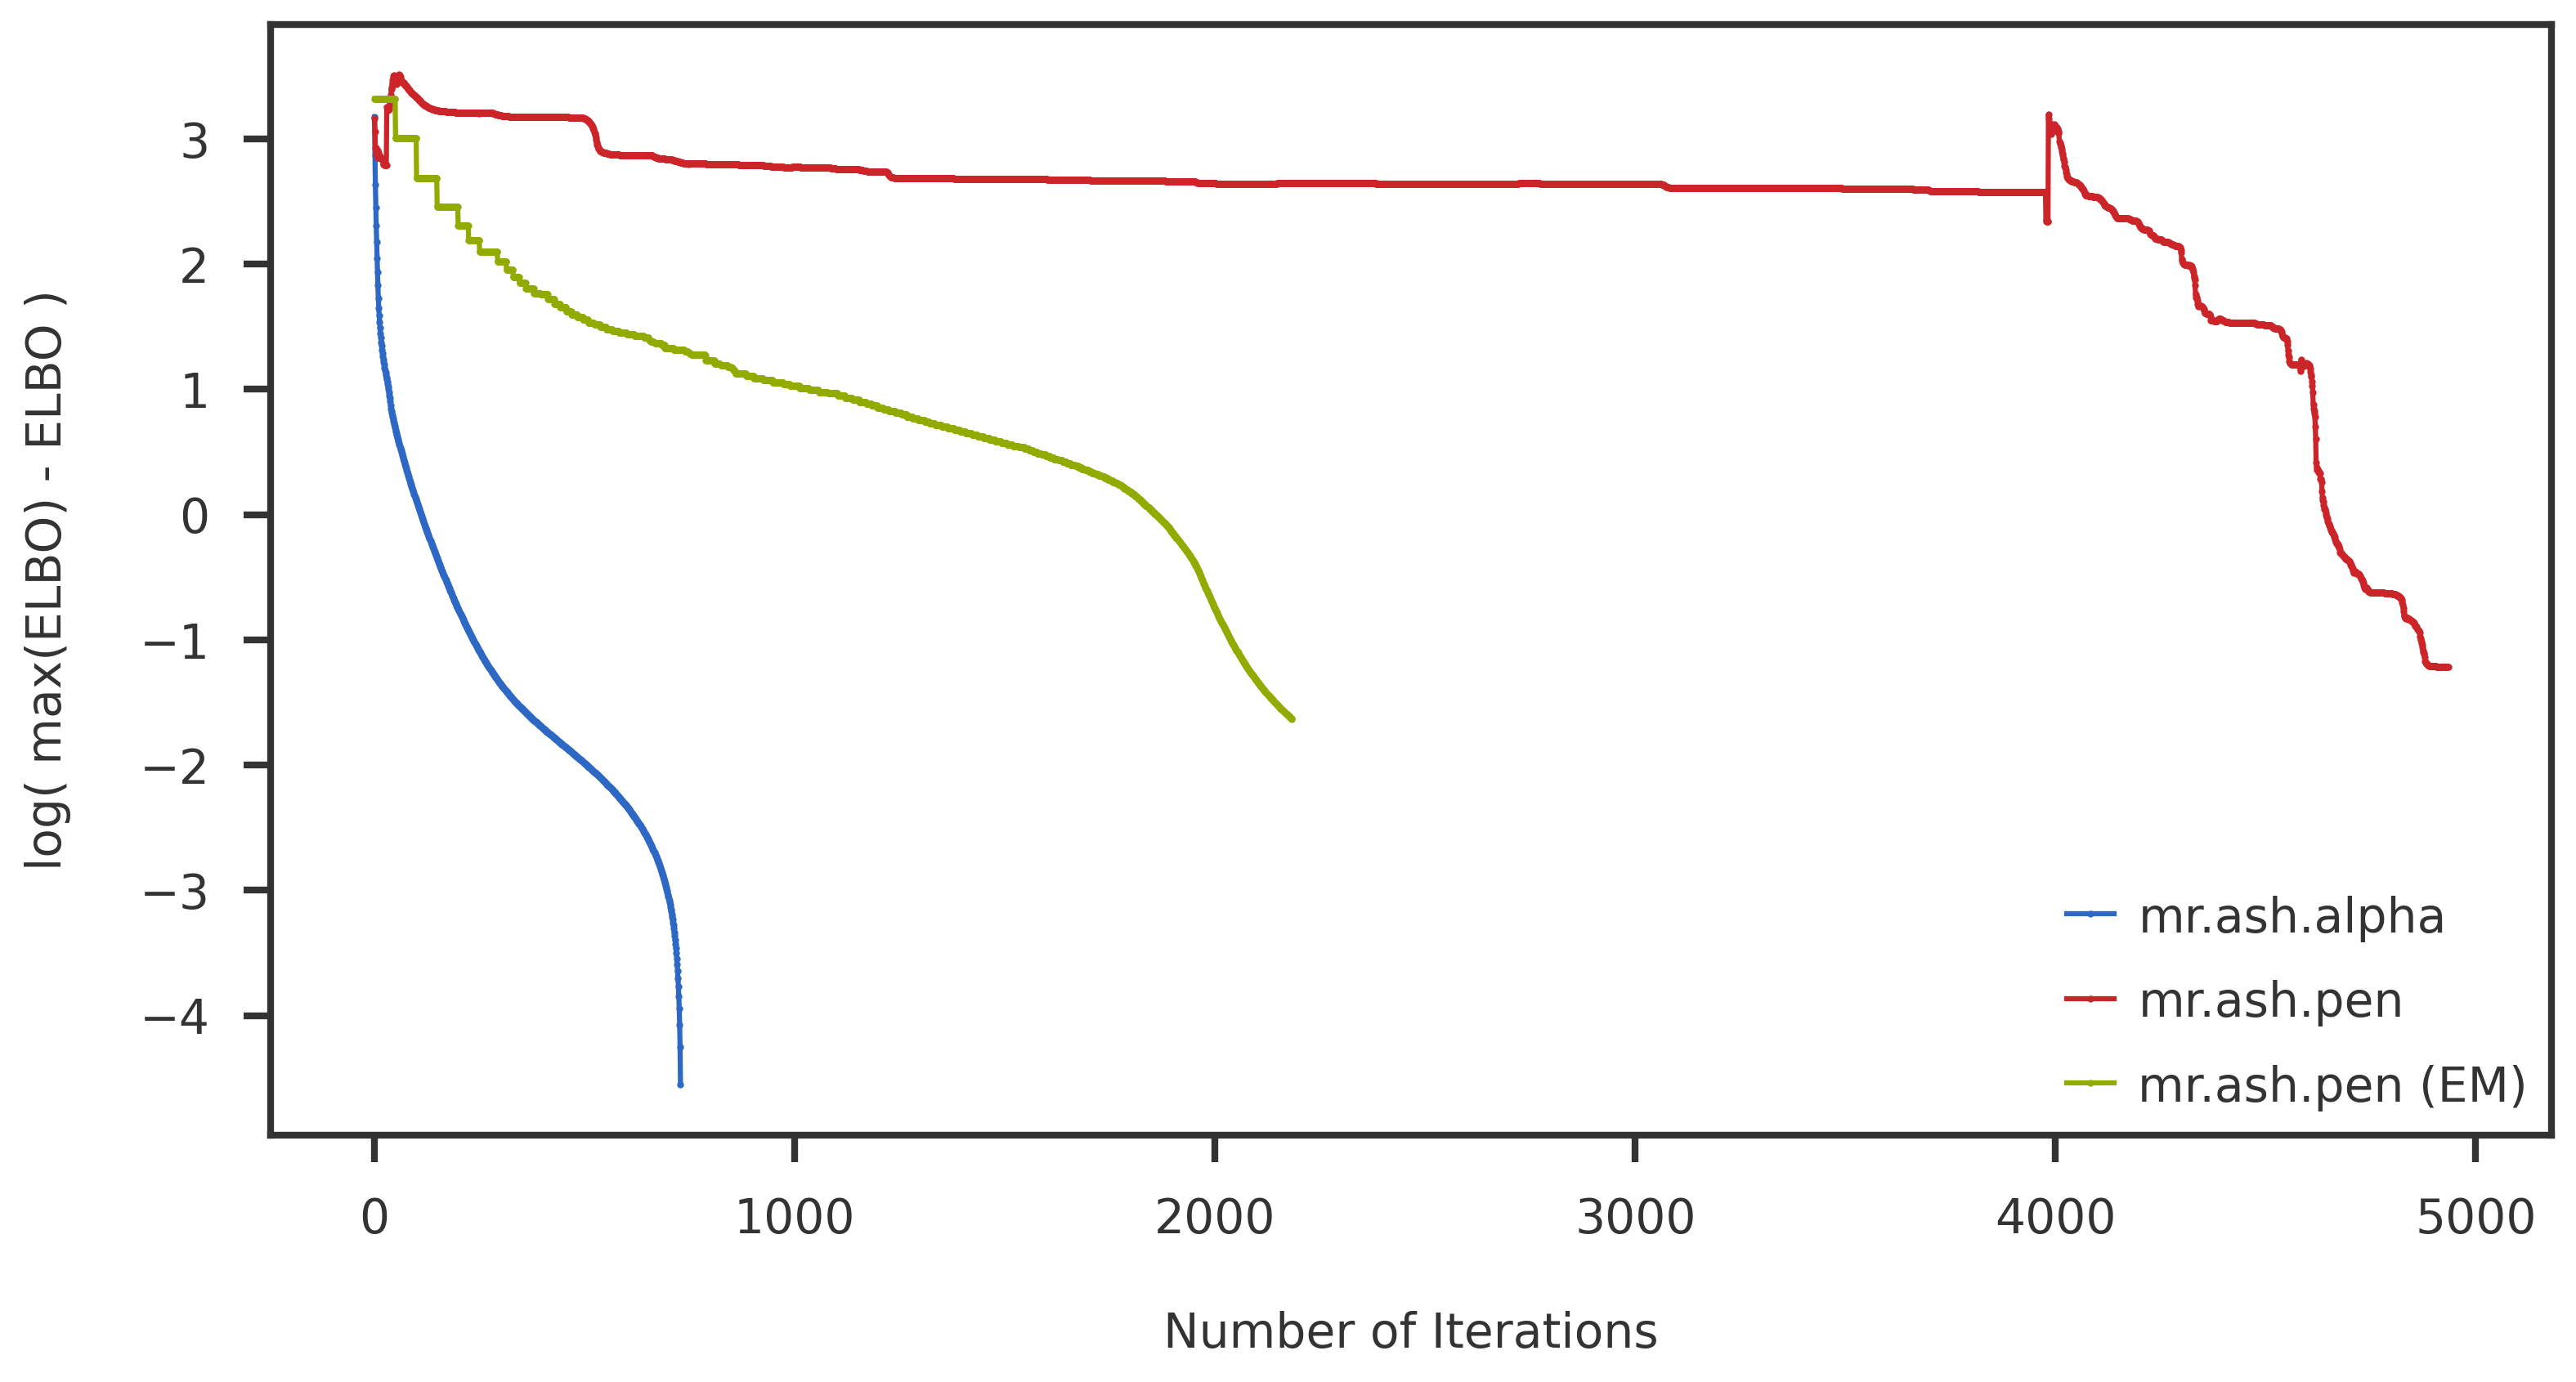

In [4]:
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     lasso_b, intercept = lasso_a0, title = 'Lasso')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue,
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.coef, intercept = plr_lbfgs.intercept, title = 'mr.ash.pen')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

kinit   = [0, 0, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_eb.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]
plot_convergence(objs, methods, kinit)

In [11]:
objs     = [mrash_r, plr_lbfgs, plr_eb, mrash_r_init]
methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)", "mr.ash.alpha (init)"]
df       = linreg_summary_df(strue, objs, methods)
df

,sigma2,ELBO,niter
True,2.274857,-,-
mr.ash.alpha,6.601390,617.911469,730
mr.ash.pen,6.644549,617.972382,4935
mr.ash.pen (EM),6.566021,617.934817,2184
mr.ash.alpha (init),6.603168,617.930057,261


In [22]:
plr_lbfgs.plr3.s2_path

[1.0507241121952036,
 0.19612027282213906,
 0.2104495093015389,
 0.20423950640238506,
 0.2036677633888266,
 0.20370661538629636]

In [26]:
plr_lbfgs.plr1.prior

array([9.63560504e-01, 4.99999975e-12, 4.99999975e-12, 4.99999975e-12,
       4.99999975e-12, 4.99999975e-12, 4.99999975e-12, 4.99999975e-12,
       4.99999975e-12, 4.99999975e-12, 4.99999975e-12, 4.99999975e-12,
       4.99999975e-12, 4.99999975e-12, 4.99999975e-12, 4.99999975e-12,
       4.99999975e-12, 4.99999975e-12, 4.99999975e-12, 3.64394961e-02])

In [27]:
plr_lbfgs.plr2.prior

array([5.65475386e-01, 3.84668621e-01, 4.78183855e-12, 4.78183855e-12,
       4.78183855e-12, 4.78183855e-12, 4.78183855e-12, 4.78183855e-12,
       4.78183855e-12, 4.78183855e-12, 4.78183855e-12, 4.78183855e-12,
       4.78183855e-12, 4.78183855e-12, 4.78183855e-12, 4.78183855e-12,
       4.78183855e-12, 4.78183855e-12, 4.78183855e-12, 4.98559927e-02])

In [14]:
plr_lbfgs.plr3.theta

array([-0.00669472,  0.01547137,  0.00270229, ...,  0.00779804,
        0.01320591, -0.0048778 ])

In [15]:
plr_lbfgs.plr3.coef

array([-1.91353907e-05,  4.56879235e-05,  7.67545104e-06, ...,
        2.23488496e-05,  3.85753361e-05, -1.38930565e-05])

In [16]:
plr_lbfgs.plr4._binit

array([-0.00669472,  0.01547137,  0.00270229, ...,  0.00779804,
        0.01320591, -0.0048778 ])

In [17]:
sk

array([0.        , 0.03526492, 0.07177346, 0.10956947, 0.14869835,
       0.18920712, 0.23114441, 0.27456063, 0.31950791, 0.36604026,
       0.41421356, 0.4640857 , 0.51571657, 0.5691682 , 0.62450479,
       0.68179283, 0.74110113, 0.80250093, 0.86606598, 0.93187266])

In [18]:
elbo_py.scalemix(X, y, sk, plr_lbfgs.plr3.coef, plr_lbfgs.plr3.prior, plr_lbfgs.plr3.residual_var)

987.1711857320839

In [19]:
from mrashpen.inference import coordinate_descent_step as cd_step
cd_step.elbo(X, y, sk, plr_lbfgs.plr3.coef, plr_lbfgs.plr3.prior, plr_lbfgs.plr3.residual_var)

758.304540585999

In [29]:
## First step in PLR4
wnew = plr_lbfgs.plr4.prior_path[0]
wnew /= np.sum(wnew)
thetanew = plr_lbfgs.plr4.theta_path[0]
bnew = plr_lbfgs.plr4.coef_path[0]
s2new = plr_lbfgs.plr4.s2_path[0]

elbo0 = cd_step.elbo(X, y, sk, plr_lbfgs.plr3.coef, plr_lbfgs.plr3.prior, plr_lbfgs.plr3.residual_var)
print (f"{elbo0:10.5f} | s, w, b from PLR3")
elbo2 = cd_step.elbo(X, y, sk, bnew, plr_lbfgs.plr3.prior, plr_lbfgs.plr3.residual_var)
print (f"{elbo2:10.5f} | s, w from PLR3 + b from first step of PLR4")
elbo4 = cd_step.elbo(X, y, sk, bnew, wnew, plr_lbfgs.plr3.residual_var)
print (f"{elbo4:10.5f} | s from PLR3 + b, w from first step of PLR4")
elbo5 = cd_step.elbo(X, y, sk, bnew, wnew, s2new)
print (f"{elbo5:10.5f} | s, w, b from first step of PLR4")
print ()
elbo1 = cd_step.elbo(X, y, sk, plr_lbfgs.plr3.coef, wnew, plr_lbfgs.plr3.residual_var)
print (f"{elbo1:10.5f} | s, b from PLR3 + w from first step of PLR4")

elbo3 = cd_step.elbo(X, y, sk, plr_lbfgs.plr3.coef, plr_lbfgs.plr3.prior, s2new)
print (f"{elbo3:10.5f} | b, w from PLR3 + s from first step of PLR4")

 838.04424 | s, w, b from PLR3
 871.08978 | s, w from PLR3 + b from first step of PLR4
2178.26779 | s from PLR3 + b, w from first step of PLR4
2178.26779 | s, w, b from first step of PLR4

2151.21058 | s, b from PLR3 + w from first step of PLR4
 838.04424 | b, w from PLR3 + s from first step of PLR4


In [30]:
elbo0 = elbo_py.scalemix(X, y, sk, plr_lbfgs.plr3.coef, plr_lbfgs.plr3.prior, plr_lbfgs.plr3.residual_var)
print (f"{elbo0:10.5f} | s, w, b from PLR3")
elbo2 = elbo_py.scalemix(X, y, sk, bnew, plr_lbfgs.plr3.prior, plr_lbfgs.plr3.residual_var)
print (f"{elbo2:10.5f} | s, w from PLR3 + b from first step of PLR4")
elbo4 = elbo_py.scalemix(X, y, sk, bnew, wnew, plr_lbfgs.plr3.residual_var)
print (f"{elbo4:10.5f} | s from PLR3 + b, w from first step of PLR4")
elbo5 = elbo_py.scalemix(X, y, sk, bnew, wnew, s2new)
print (f"{elbo5:10.5f} | s, w, b from first step of PLR4")
print ()
elbo1 = elbo_py.scalemix(X, y, sk, plr_lbfgs.plr3.coef, wnew, plr_lbfgs.plr3.residual_var)
print (f"{elbo1:10.5f} | s, b from PLR3 + w from first step of PLR4")

elbo3 = elbo_py.scalemix(X, y, sk, plr_lbfgs.plr3.coef, plr_lbfgs.plr3.prior, s2new)
print (f"{elbo3:10.5f} | b, w from PLR3 + s from first step of PLR4")


 840.92714 | s, w, b from PLR3
1162.56944 | s, w from PLR3 + b from first step of PLR4
5179.02933 | s from PLR3 + b, w from first step of PLR4
5179.02939 | s, w, b from first step of PLR4

2322.38736 | s, b from PLR3 + w from first step of PLR4
 840.92714 | b, w from PLR3 + s from first step of PLR4


array([1.97295013e+03, 1.00000000e-08, 1.00000000e-08, 1.00000000e-08,
       1.00000000e-08, 1.00000000e-08, 1.00000000e-08, 1.00000000e-08,
       1.00000000e-08, 1.00000000e-08, 6.90697924e+00, 1.04162418e+01,
       9.77028879e+00, 1.00000000e-08, 1.00000000e-08, 1.00000000e-08,
       1.00000000e-08, 1.00000000e-08, 1.00000000e-08, 1.00000000e-08])

In [2]:
n = 200
p = 2000
p_causal = 10
pve = 0.95
rho = 0.95
k = 20

X, y, Xtest, ytest, btrue, strue = simulate.equicorr_predictors(n, p, p_causal, pve, rho = rho, seed = 10)
X      = center_and_scale(X)
Xtest  = center_and_scale(Xtest)
wk, sk = initialize_ash_prior(k, scale = 2)

In [3]:
'''
Lasso initialization
'''
lasso_a0, lasso_b, _ = R_lasso.fit(X, y)
s2init = np.var(y - np.dot(X, lasso_b) - lasso_a0)

'''
mr.ash.pen
'''
# plr_lbfgs = PLR(method = 'L-BFGS-B', optimize_w = True, optimize_s = False, is_prior_scaled = True,
#                 debug = False, display_progress = False, calculate_elbo = True, maxiter = 2000)
# plr_lbfgs.fit(X, y, sk, binit = None, winit = wk, s2init = s2init)
plr_lbfgs = lbfgsfit.method_fixseq(X, y, sk, wk, binit = lasso_b, s2init = s2init, calculate_elbo = True)


'''
mr.ash.pen (EM)
'''
plr_eb = ebfit(X, y, sk, wk, binit = lasso_b, s2init = 1, maxiter = 200, qb_maxiter = 100)


'''
mr.ash.alpha
'''
mrash_r = MrASHR(option = "r2py", debug = False)
mrash_r.fit(X, y, sk, binit = lasso_b, winit = wk, s2init = 1)


'''
mr.ash.alpha (init)
'''
mrash_r_init = MrASHR(option = "r2py", debug = False)
mrash_r_init.fit(X, y, sk, binit = plr_lbfgs.coef, winit = plr_lbfgs.prior, s2init = plr_lbfgs.residual_var)

R[write to console]: Loading required package: Matrix



mr.ash.pen terminated at iteration 43.
mr.ash.pen terminated at iteration 6.
mr.ash.pen terminated at iteration 17.
mr.ash.pen terminated at iteration 75.
mr.ash.pen (EM) terminated at iteration 200.
Mr.ASH terminated at iteration 348.
Mr.ASH terminated at iteration 327.


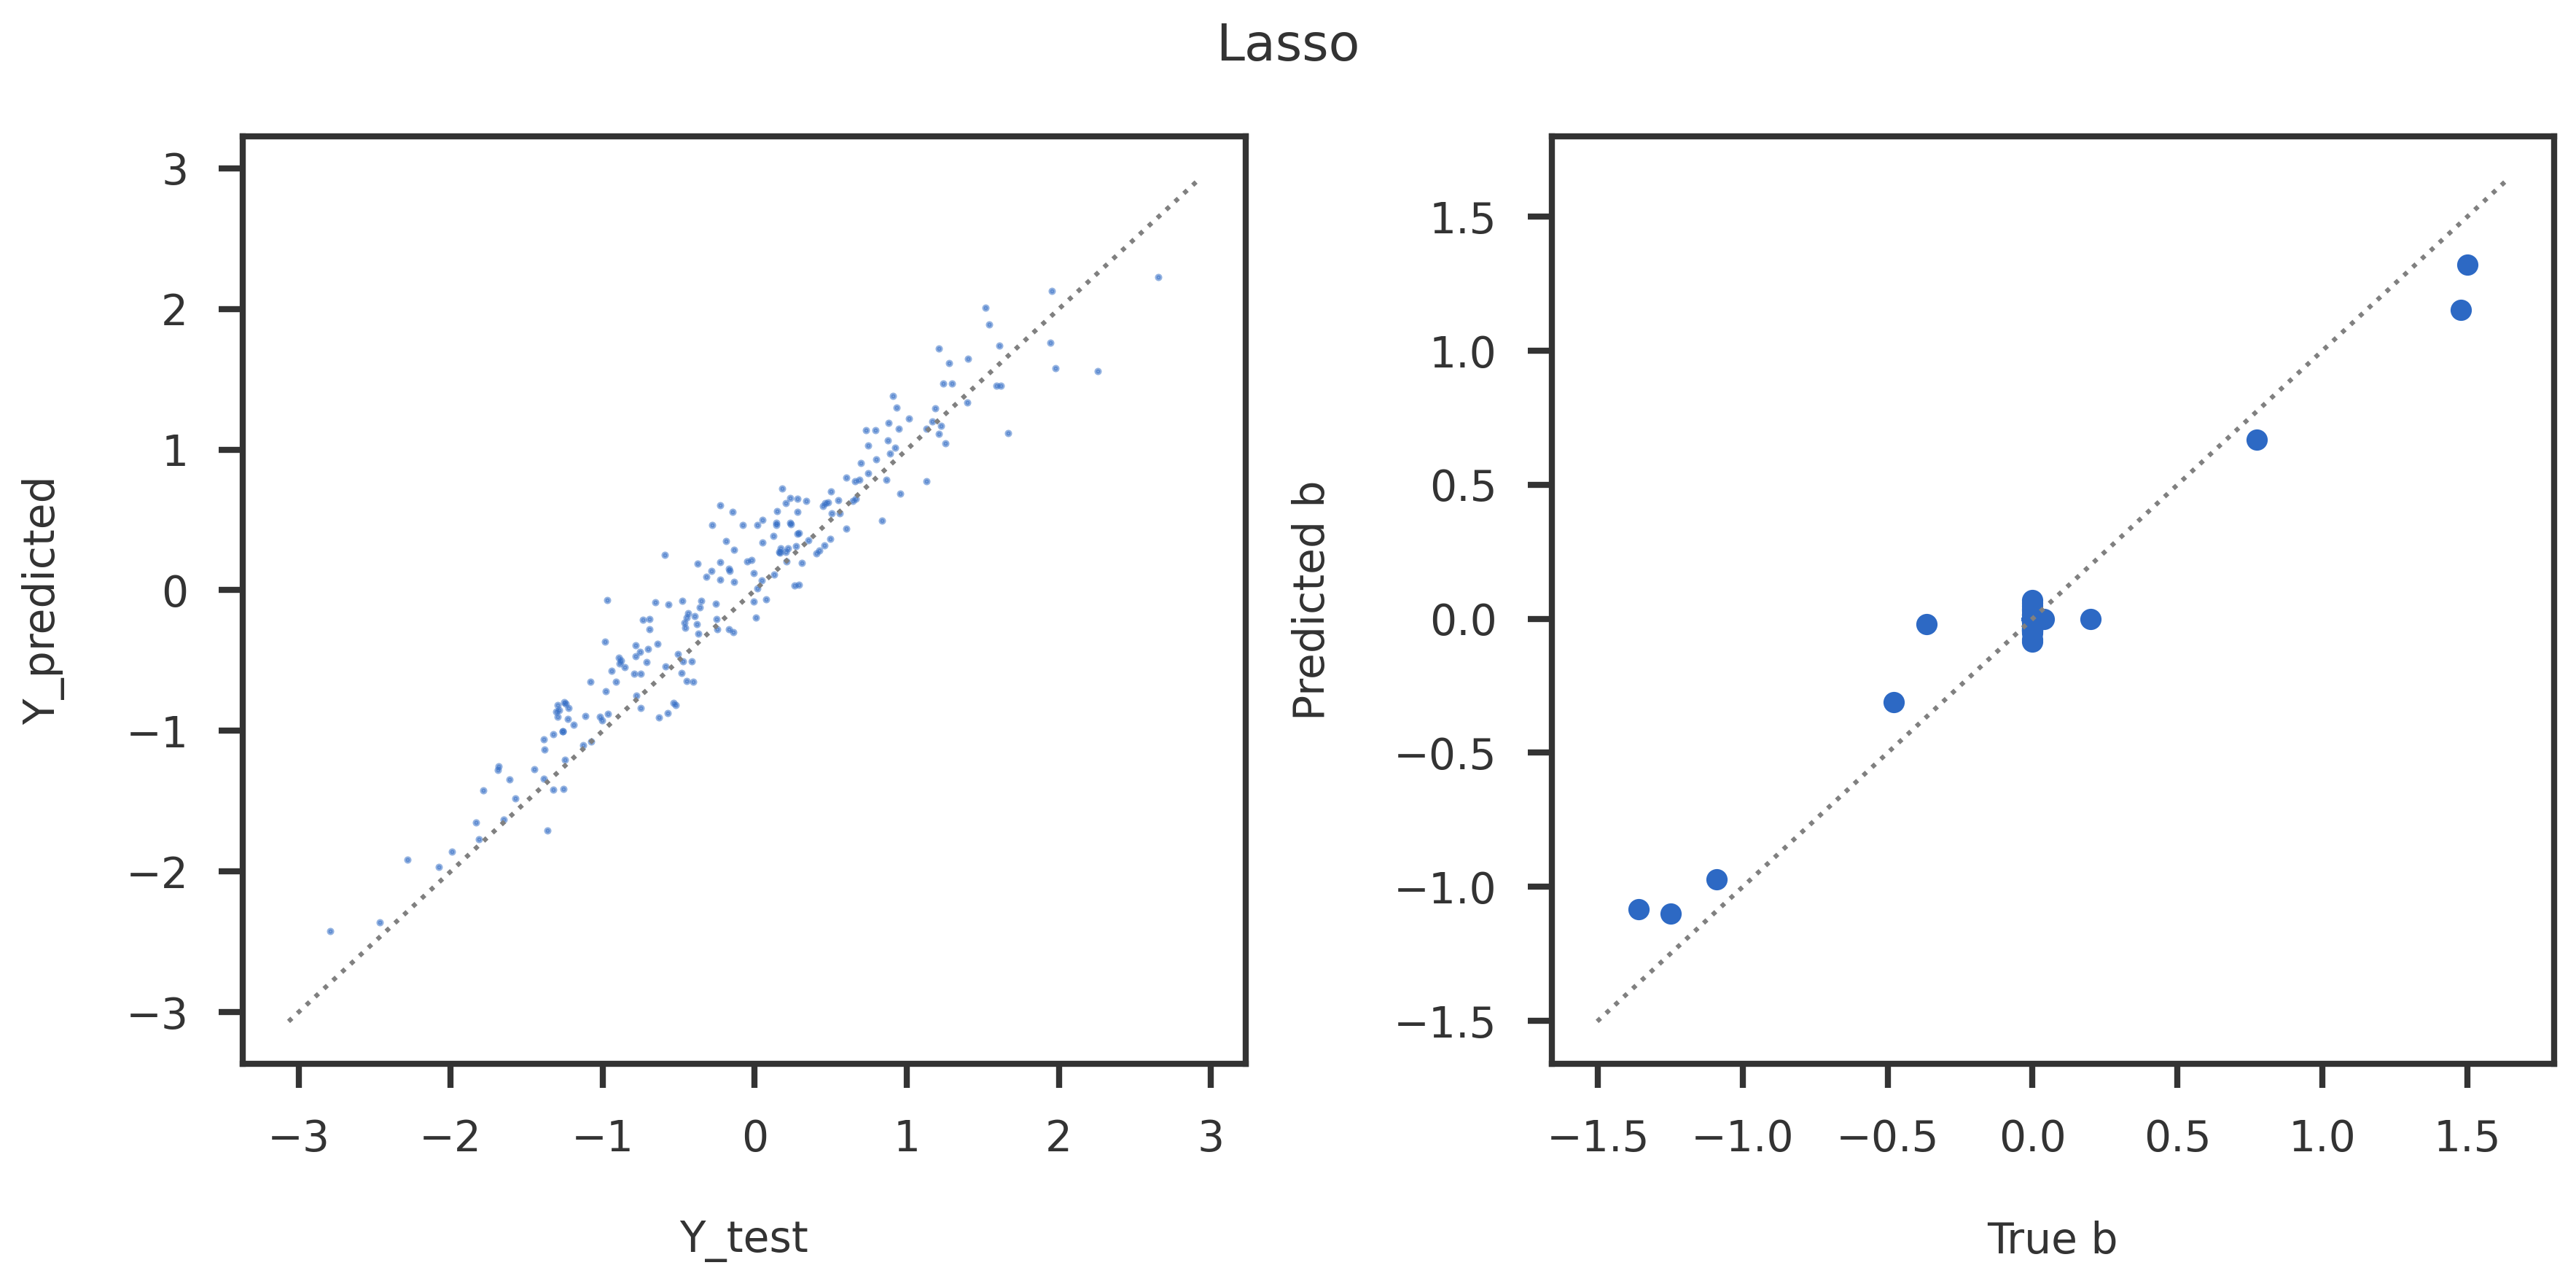

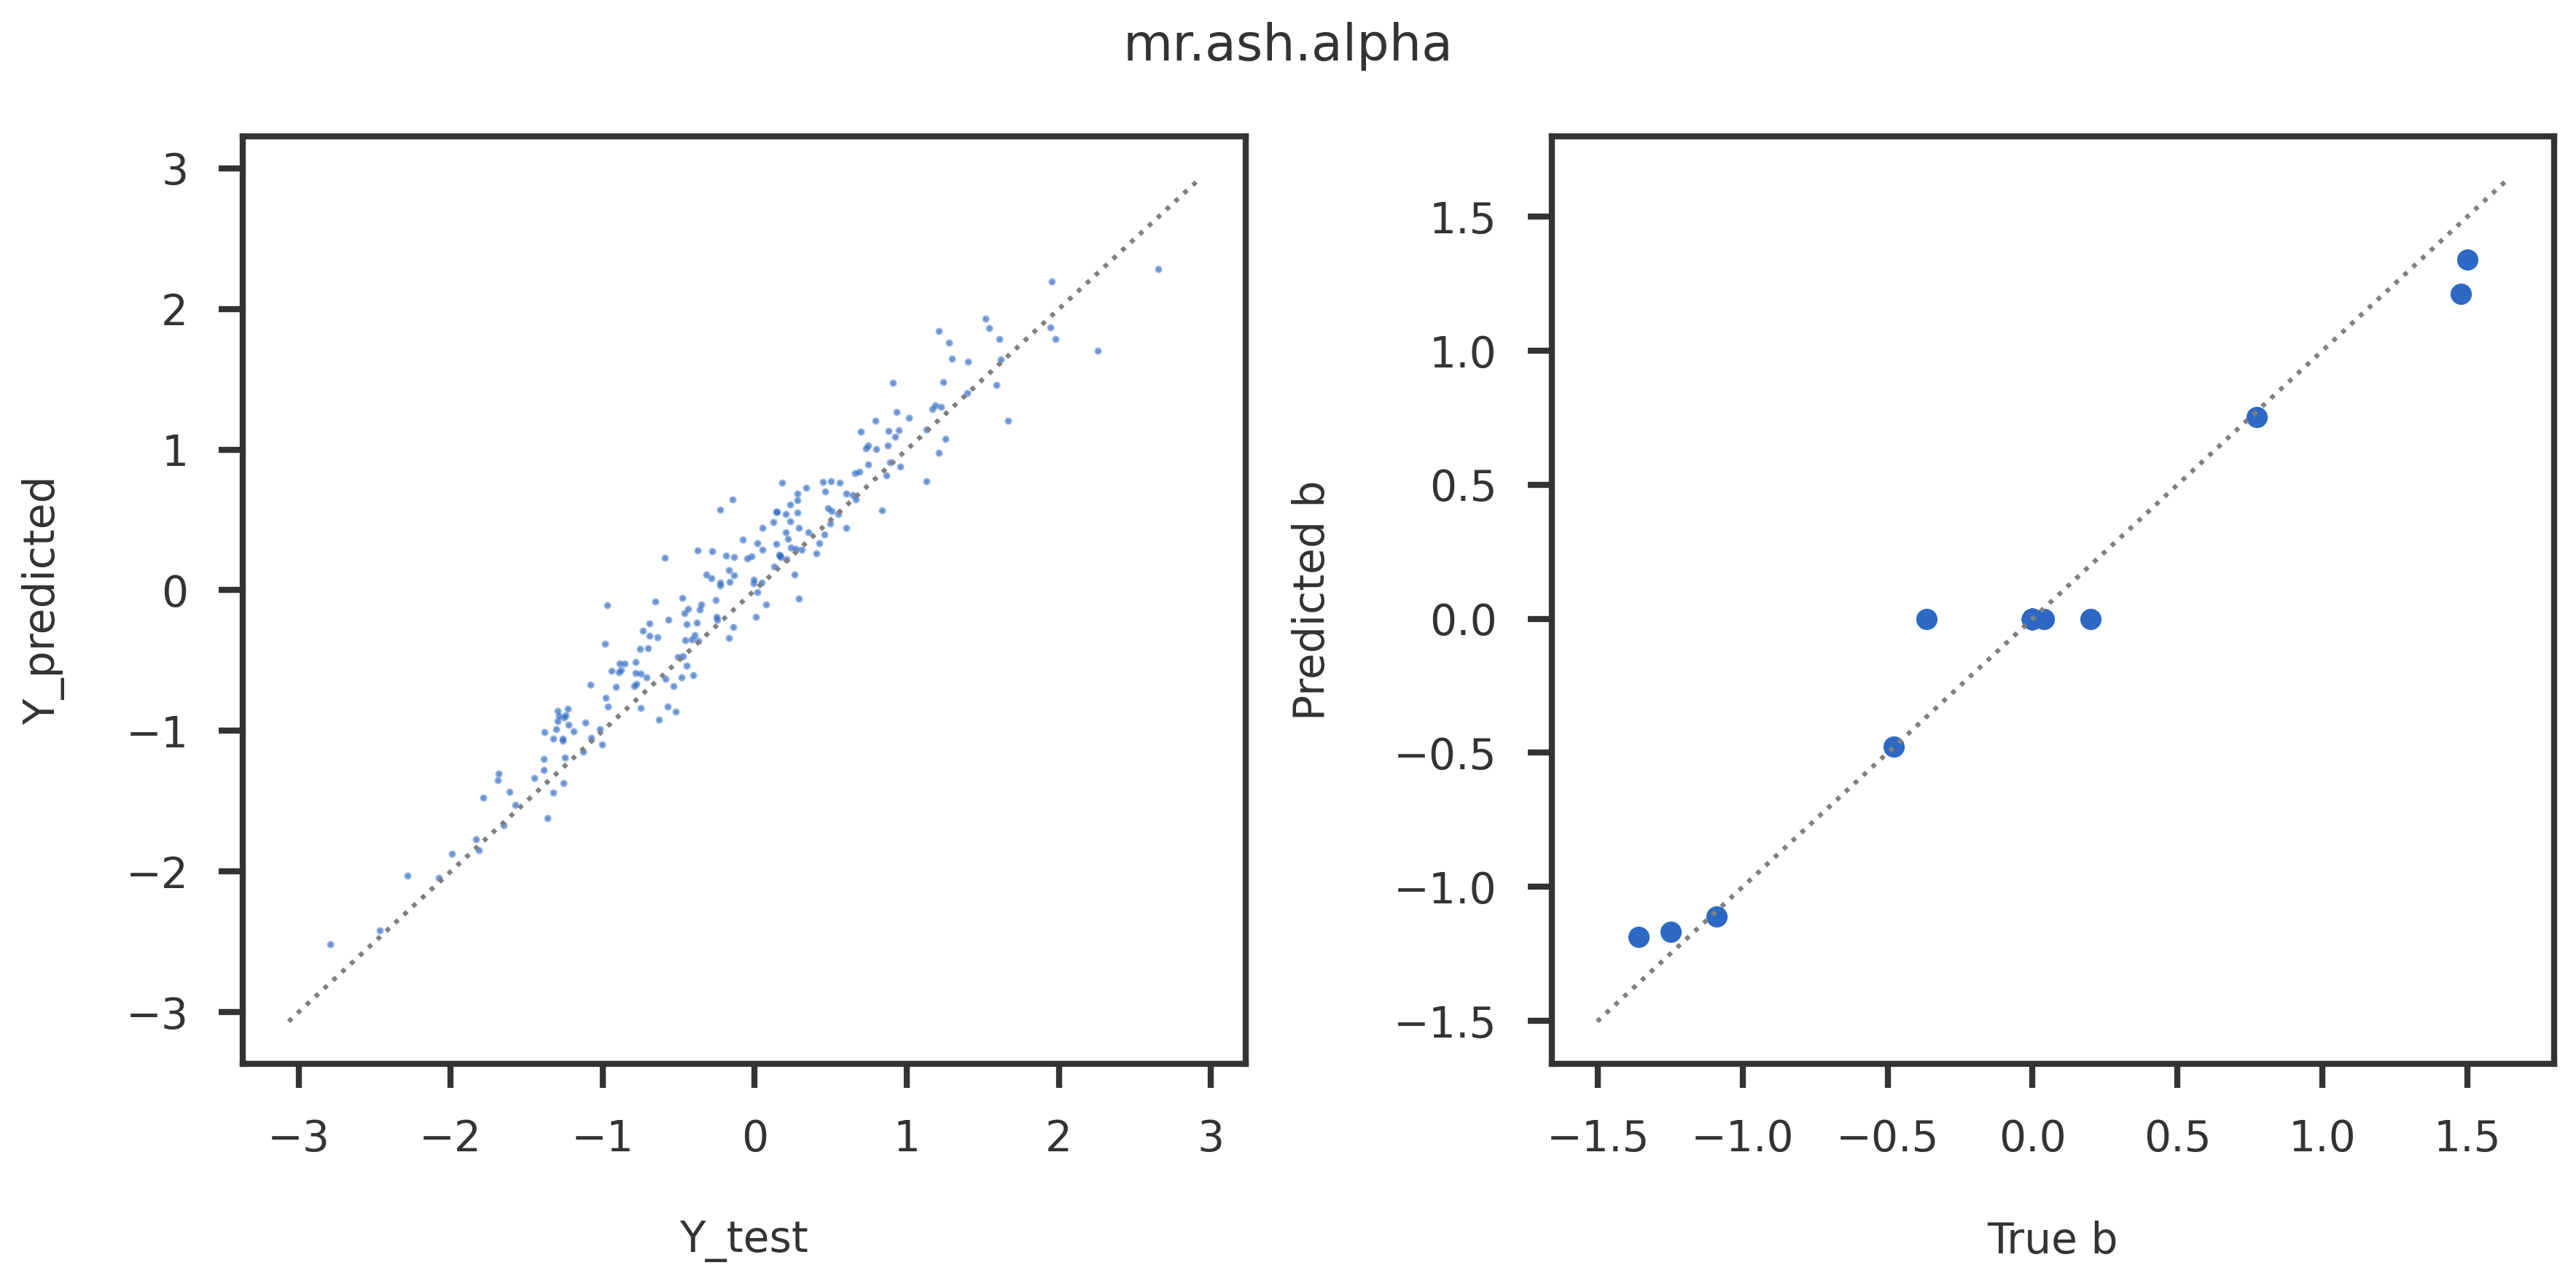

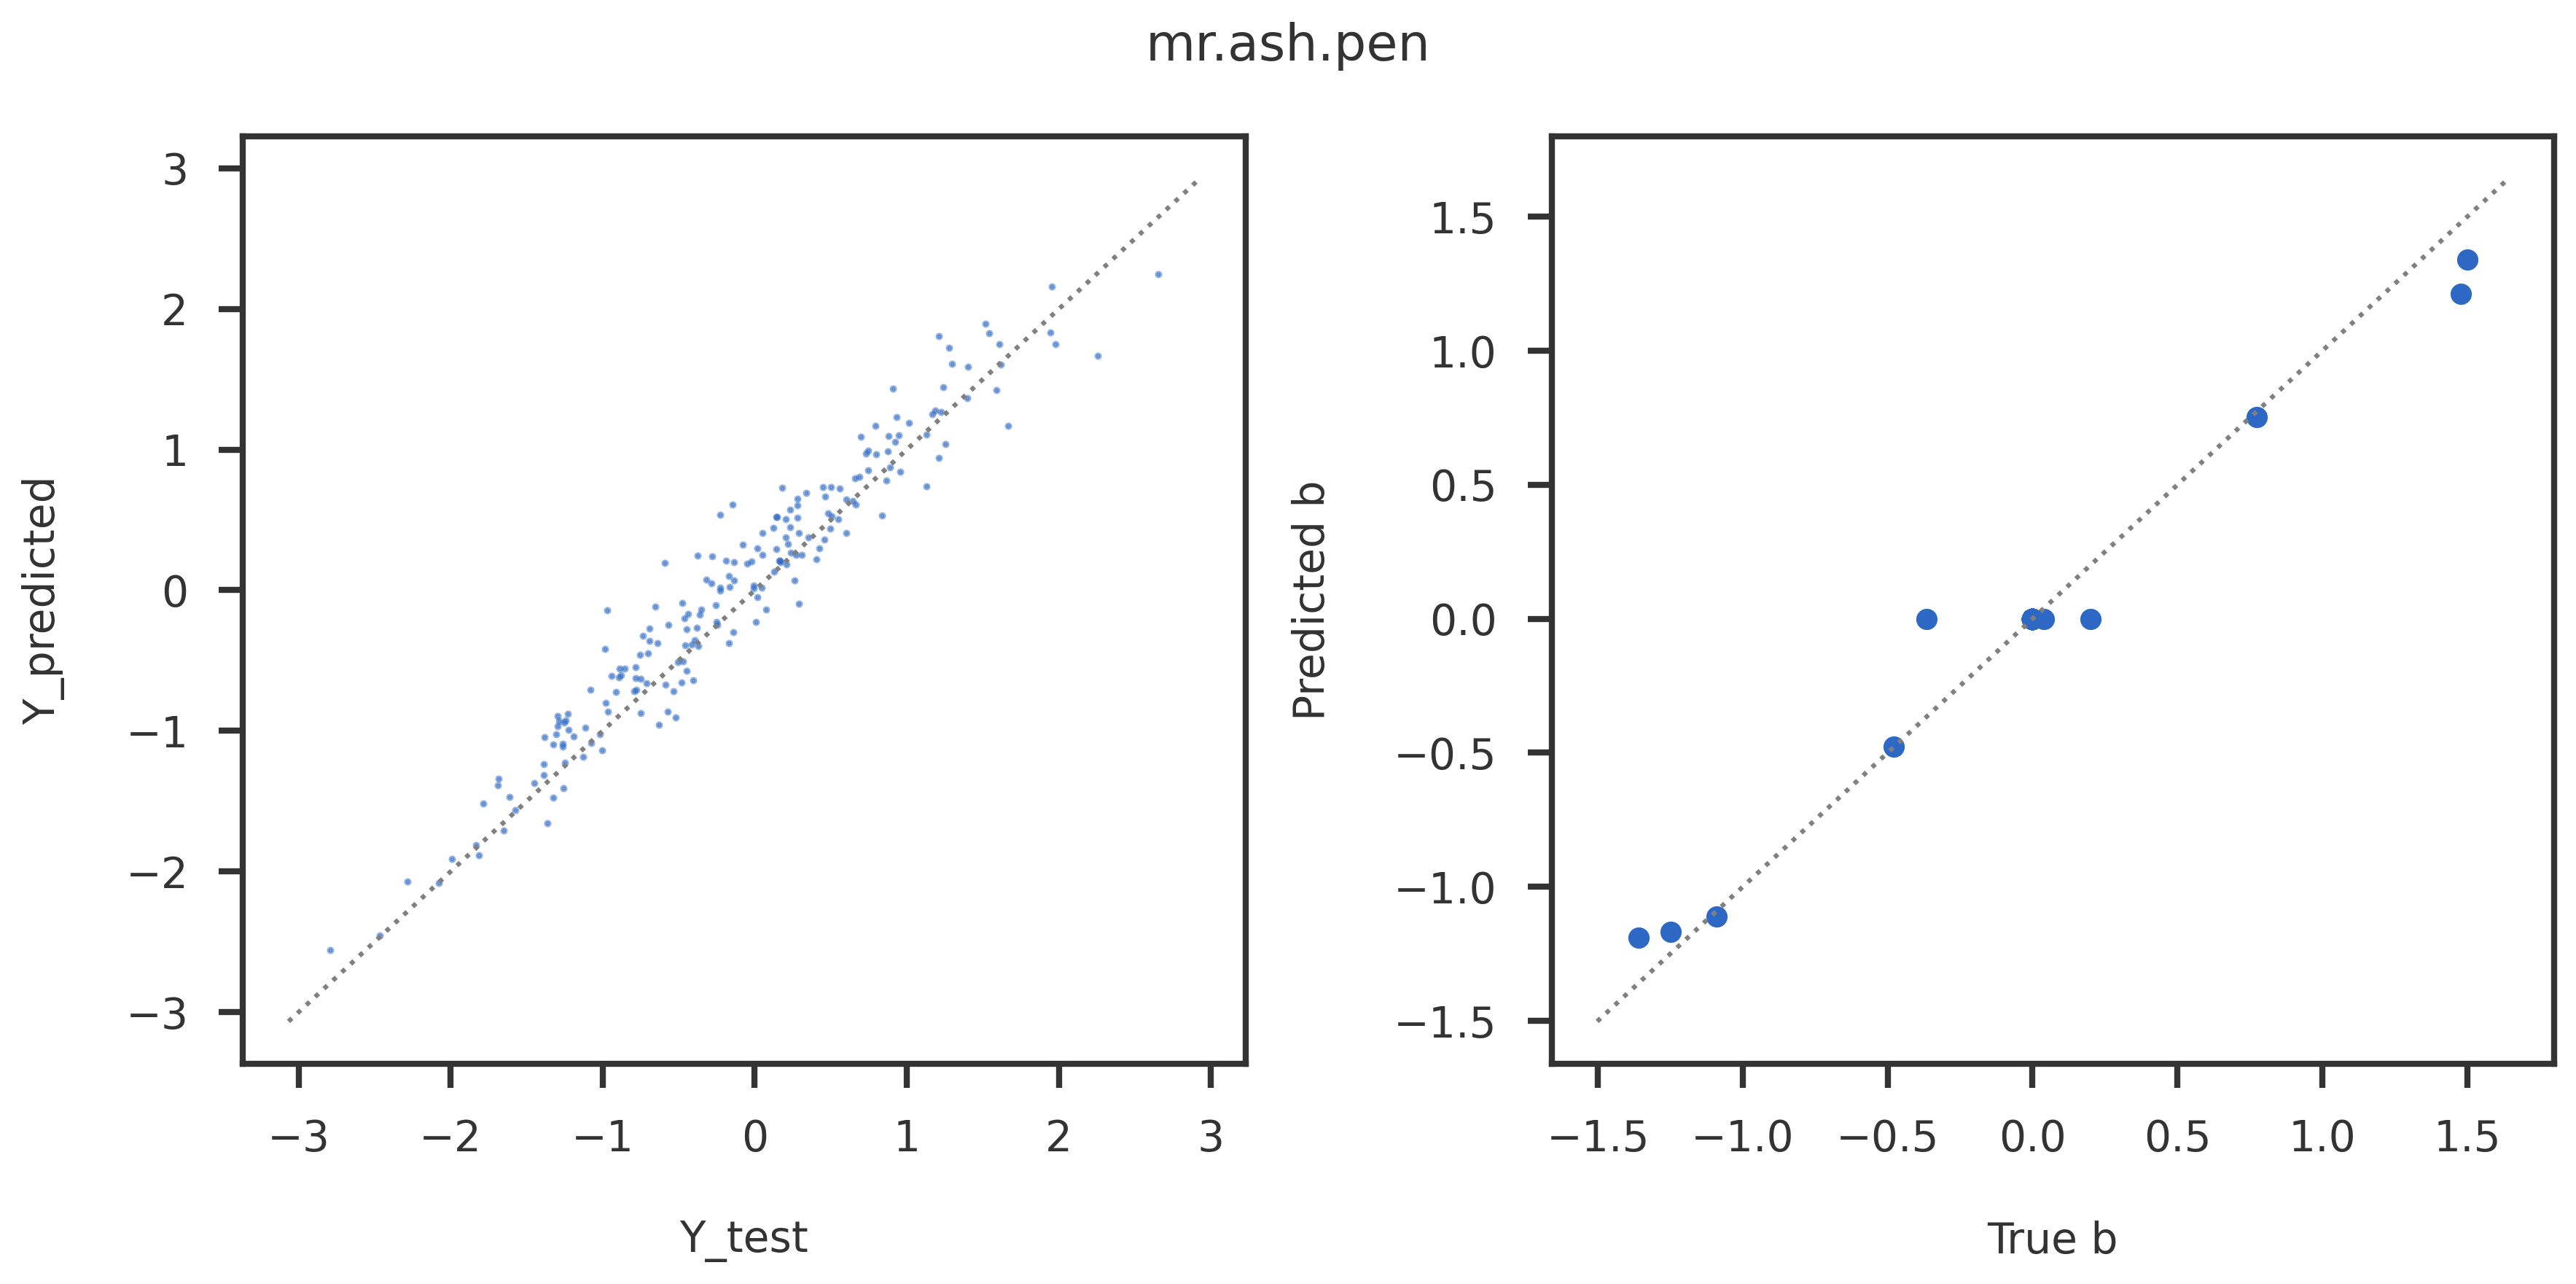

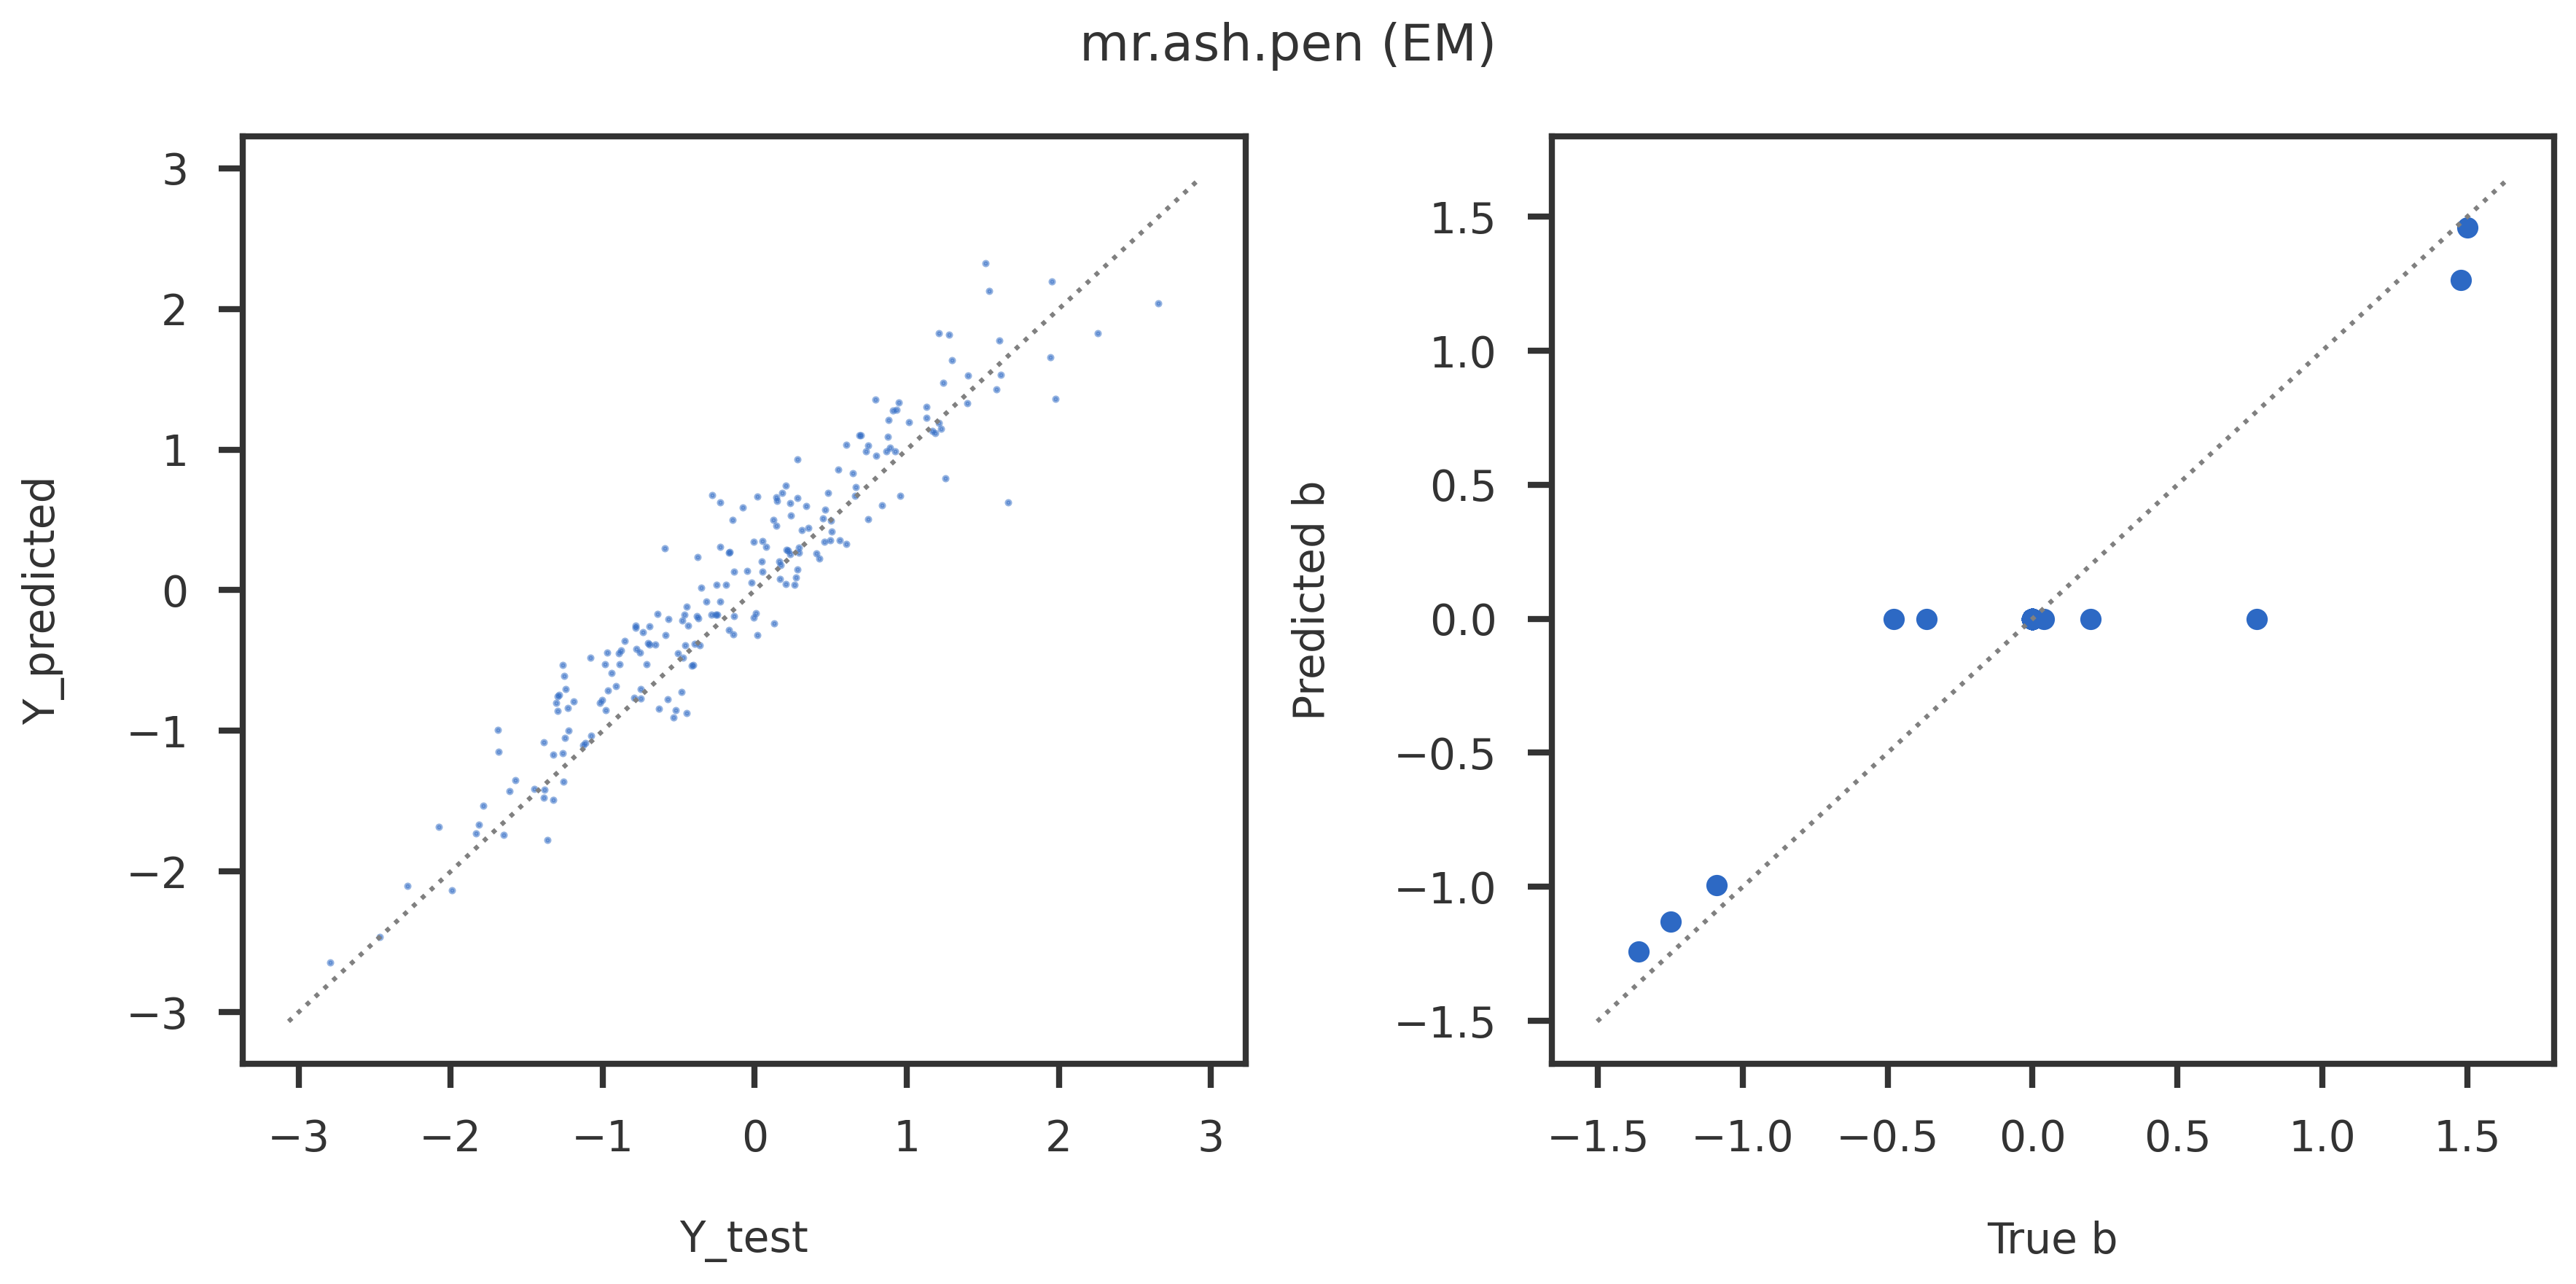

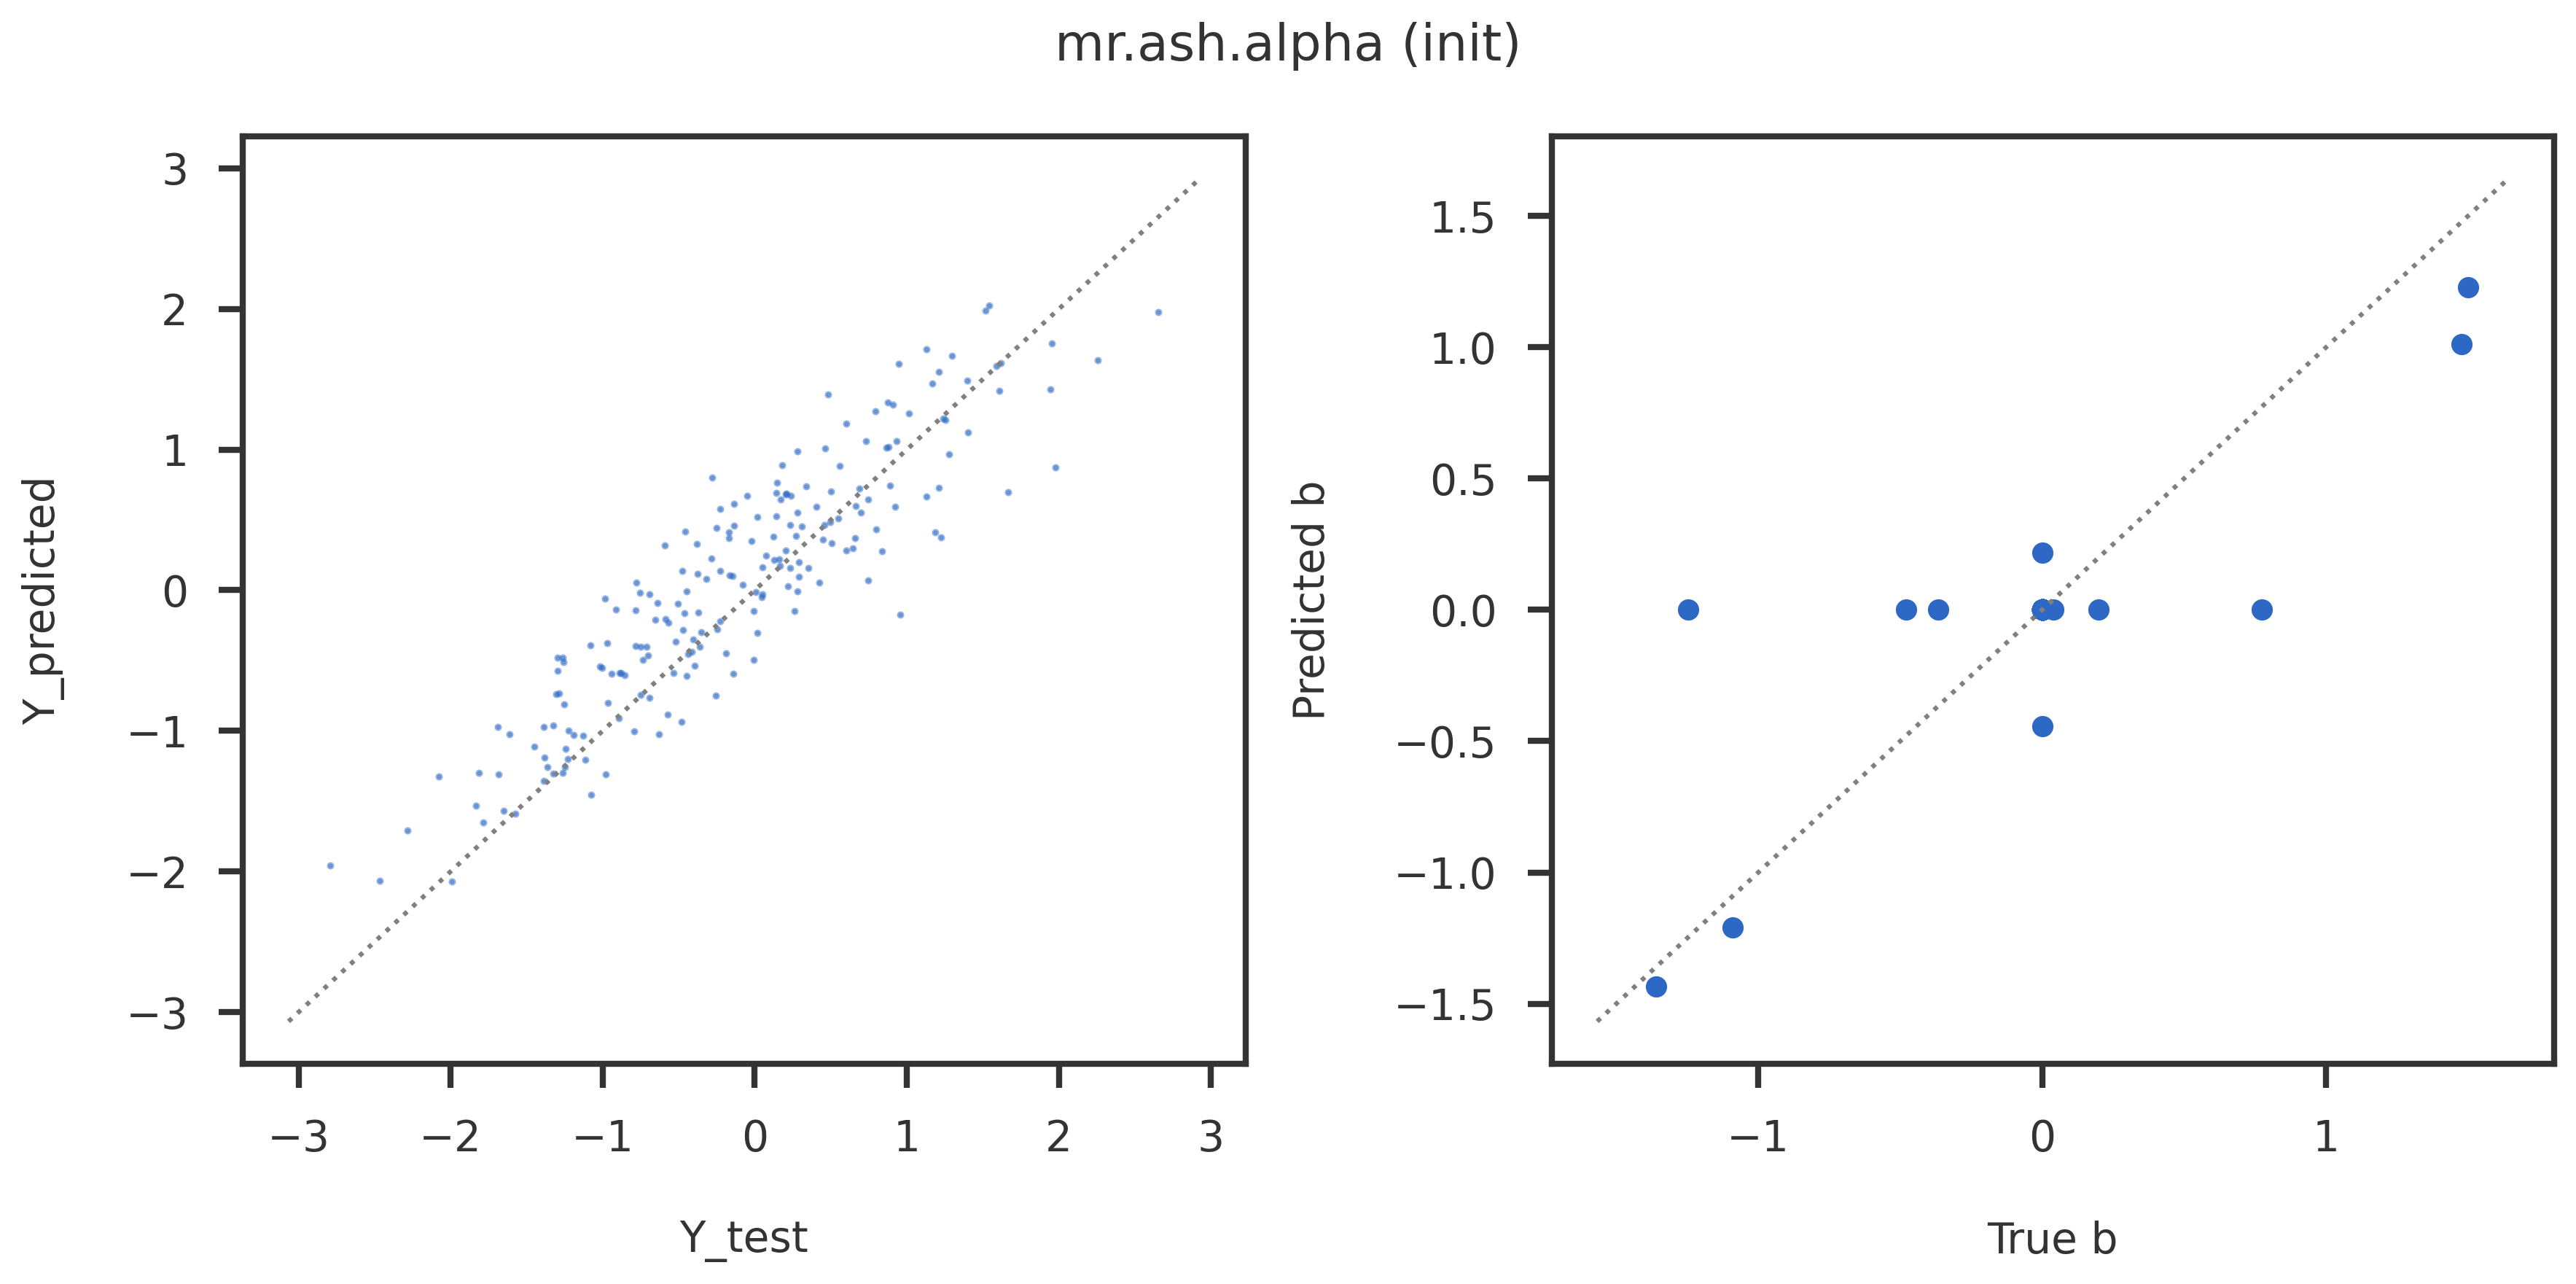

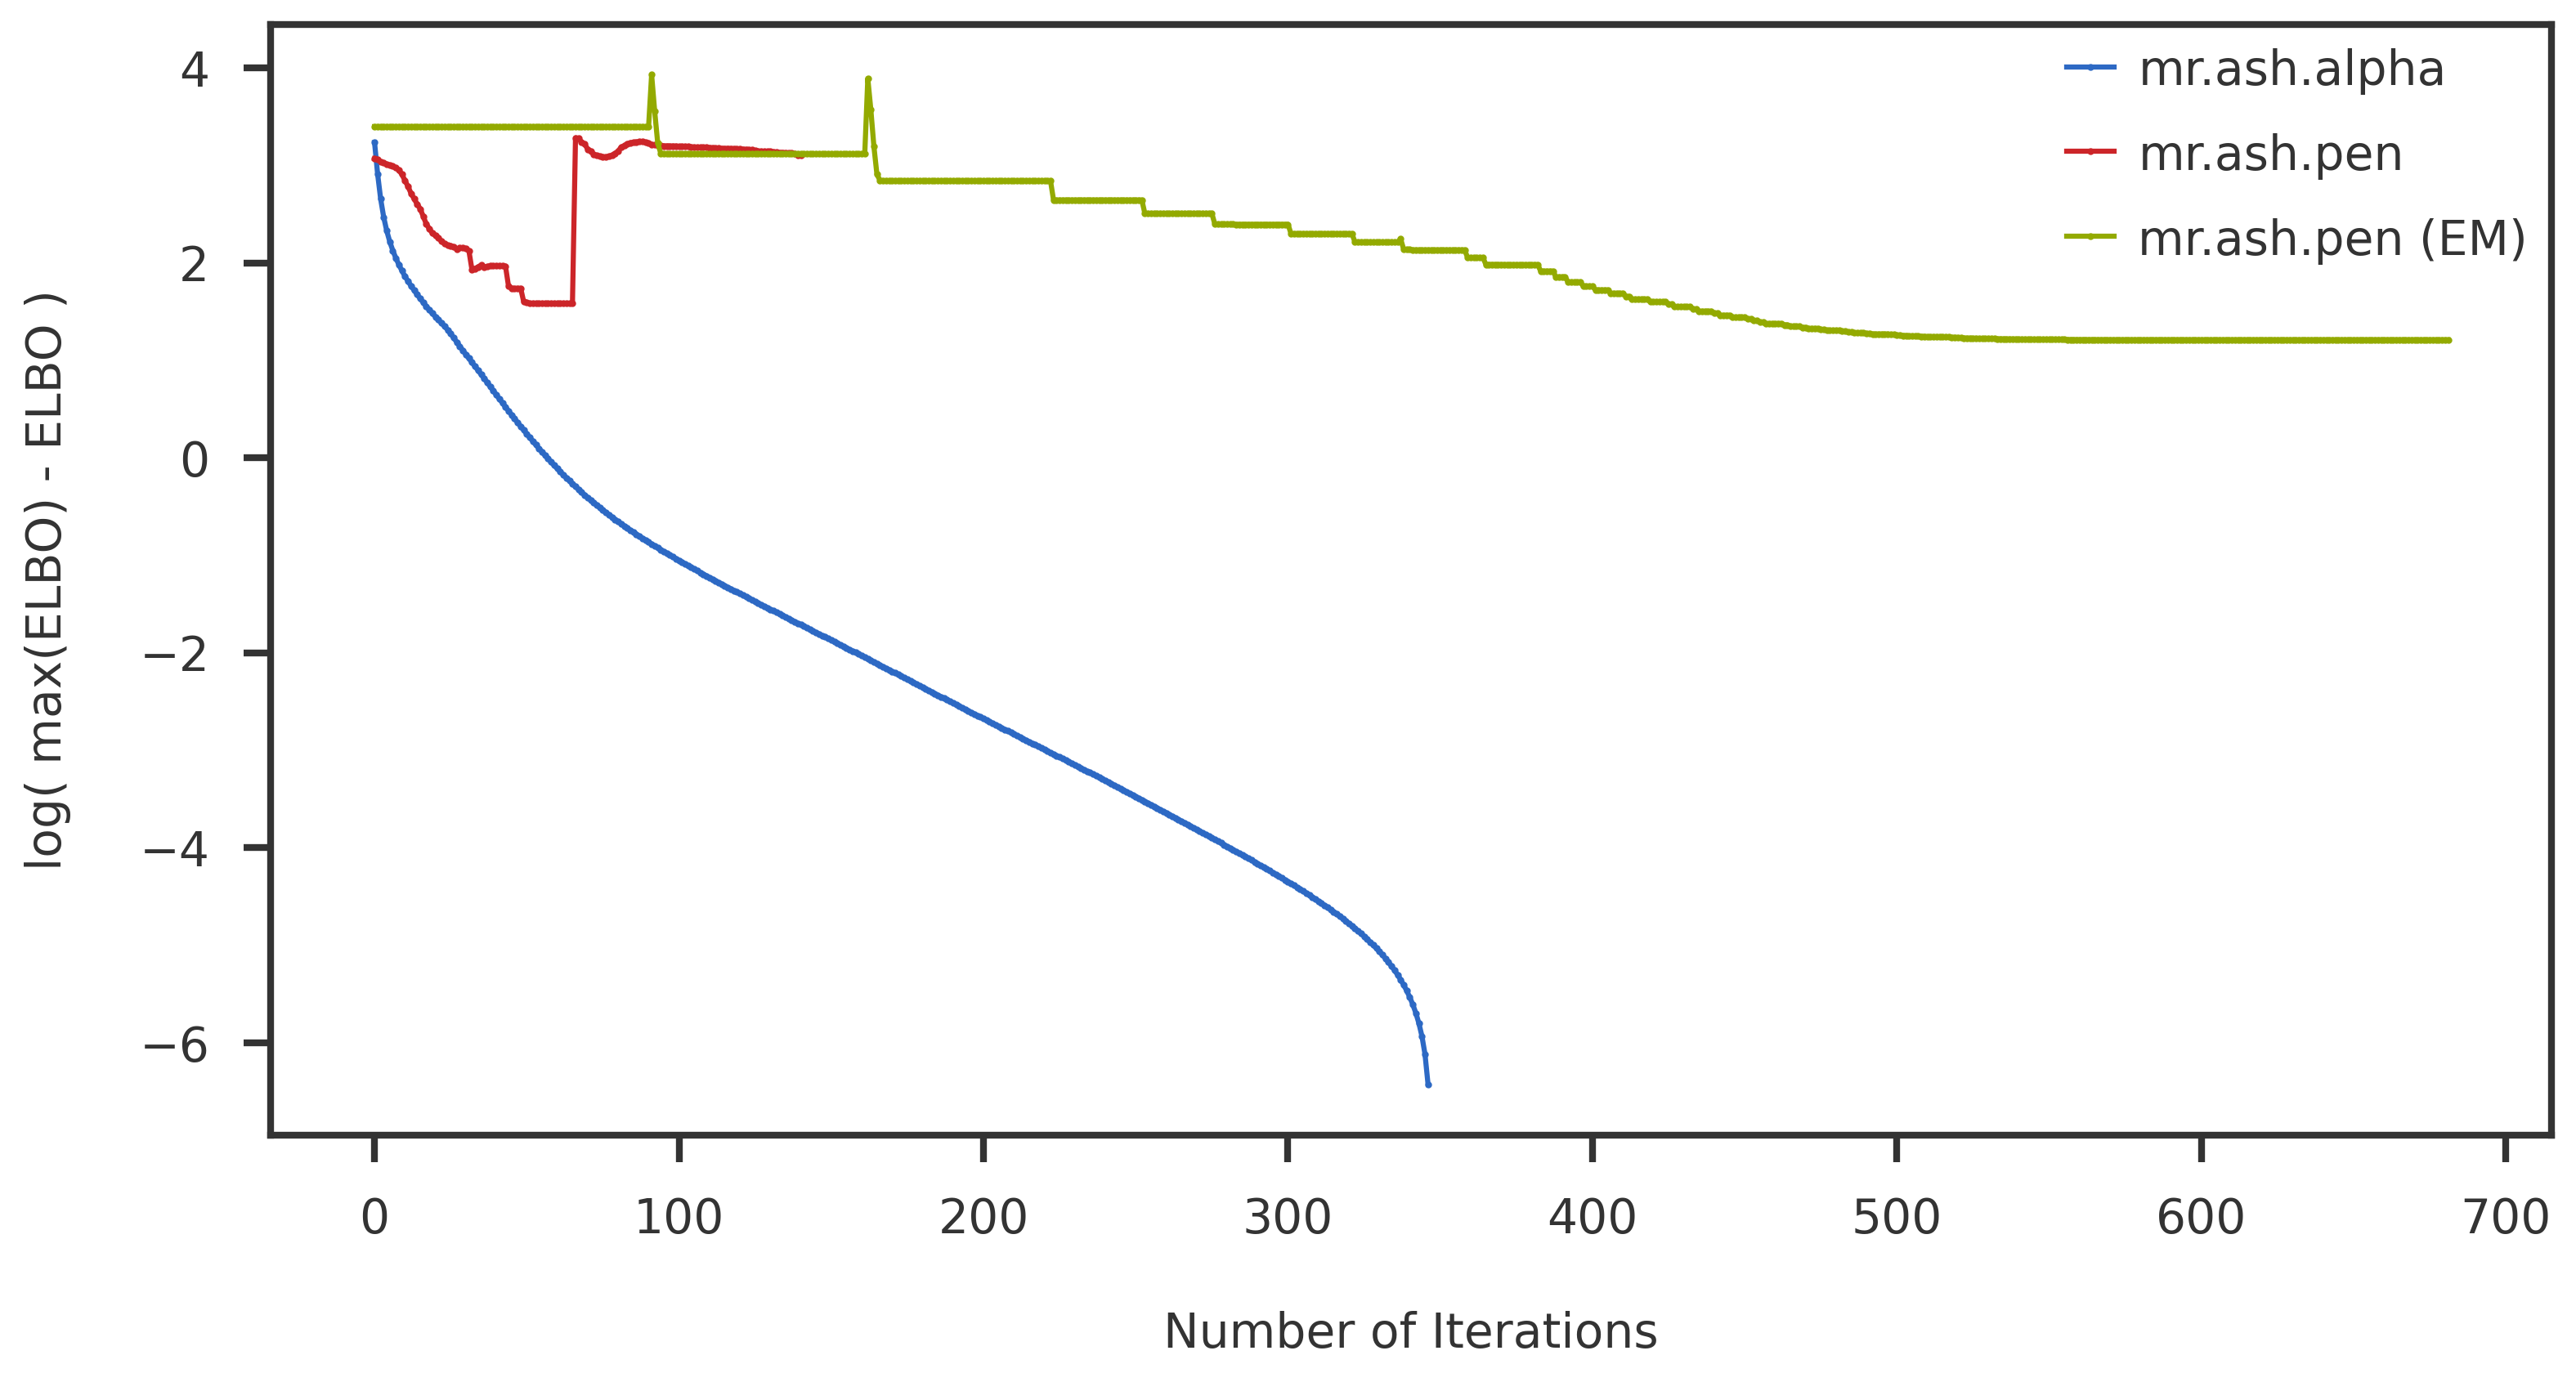

In [15]:
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     lasso_b, intercept = lasso_a0, title = 'Lasso')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue,
                     mrash_r.coef, intercept = mrash_r.intercept, title = 'mr.ash.alpha')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_lbfgs.plr3.coef, intercept = plr_lbfgs.plr3.intercept, title = 'mr.ash.pen')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     plr_eb.coef, intercept = plr_eb.intercept, title = 'mr.ash.pen (EM)')
plot_linear_mrashpen(X, y, Xtest, ytest, btrue, strue, 
                     mrash_r_init.coef, intercept = mrash_r_init.intercept, title = 'mr.ash.alpha (init)')

kinit   = [0, 0, 0]
objs    = [mrash_r.obj_path, plr_lbfgs.elbo_path, plr_eb.elbo_path]
methods = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)"]
plot_convergence(objs, methods, kinit)

In [44]:
objs     = [mrash_r, plr_lbfgs, plr_eb, mrash_r_init]
methods  = ["mr.ash.alpha", "mr.ash.pen", "mr.ash.pen (EM)", "mr.ash.alpha (init)"]
df       = linreg_summary_df(strue, objs, methods)
df

,sigma2,ELBO,niter
True,0.043211,-,-
mr.ash.alpha,0.104509,122.031837,348
mr.ash.pen,0.641109,1389.767613,141
mr.ash.pen (EM),0.145124,138.236222,682
mr.ash.alpha (init),0.206988,182.143576,327


In [40]:
plr_lbfgs.prior

array([0.19062361, 0.16473721, 0.12211105, 0.09030807, 0.06939418,
       0.05532371, 0.04540779, 0.03811145, 0.03254859, 0.02818591,
       0.02468593, 0.02182636, 0.01945766, 0.01747799, 0.01581846,
       0.01443776, 0.0133224 , 0.01248547, 0.01195873, 0.01177767])

In [43]:
plr_lbfgs.plr4.residual_var

0.641108648351232

In [24]:
'''
mr.ash.pen
'''
plr_lbfgs = lbfgsfit.method_fixseq(X, y, sk, wk, binit = lasso_b, s2init = s2init, calculate_elbo = False)

mr.ash.pen terminated at iteration 74.
mr.ash.pen terminated at iteration 7.
mr.ash.pen terminated at iteration 258.


In [22]:
plr_lbfgs.plr3.residual_var

102.86695704025809